In [1]:
import math
import pandas as pd
import tensorflow as tf
# import keras_tuner.tuners as kt
import matplotlib.pyplot as plt
import keras
from tensorflow.keras import Model
from tensorflow.keras import Sequential
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.layers import Dense, Dropout
from sklearn.model_selection import train_test_split
from tensorflow.keras.losses import MeanSquaredLogarithmicError
import numpy as np
import pickle
np.random.seed(0)
from tensorflow.keras import Input
from tensorflow.keras.layers import Conv1D, Conv2D, LeakyReLU, MaxPool1D, AveragePooling1D, UpSampling1D, Flatten, Dense, Reshape, BatchNormalization
# https://towardsdatascience.com/improve-your-model-performance-with-auto-encoders-d4ee543b4154
from tensorflow.keras import initializers
from sklearn.decomposition import PCA
from matplotlib.pyplot import figure
from scipy.spatial.distance import cdist
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_samples, silhouette_score

import matplotlib.pyplot as plt
import matplotlib.cm as cm
import numpy as np
from keras.wrappers.scikit_learn import KerasRegressor
from sklearn.model_selection import GridSearchCV

from keras.optimizers import Adam, SGD, Adadelta

In [2]:
x_train_scaled = pd.read_csv('260_sample_train_scaled.csv').set_index("Patient_ID")
x_train_scaled

,AADAC,APOA1,APOA4,APOB,APOC3,AQP9,C6,CEACAM7,CHI3L1,ABCC2,...,TAF15,ZFYVE20,LOC100420253,LY6G5B,C5orf58,RSL24D1P1,MIEN1,PCBP1_AS1,LOC100133165,DNAJB8
Patient_ID,,,,,,,,,,,,,,,,,,,,,
55_control,0.702813,0.799052,0.719665,0.729547,0.794953,0.256451,1.000000,0.363133,0.374212,0.611161,...,0.468042,0.335792,0.0,0.609518,0.535456,0.0,0.543158,0.622641,0.0,1.0
168_CD_plain,0.751408,0.603707,0.622768,0.627712,0.606860,0.520576,0.311962,0.251356,0.553554,0.441131,...,0.000000,0.159464,0.0,0.173529,0.018188,0.0,0.623796,0.301179,0.0,0.0
72_control,0.786508,0.755331,0.739605,0.756170,0.819875,0.391132,0.648401,0.134017,0.200420,0.679453,...,0.335173,0.241577,0.0,0.659563,0.000000,0.0,0.853118,0.431083,0.0,0.0
120_control,0.707491,0.662993,0.648072,0.764621,0.654276,0.633929,0.579519,0.248934,0.759250,0.755407,...,0.181256,0.297248,0.0,0.837676,0.480372,0.0,0.392582,0.390569,0.0,0.0
258_CD_plain,0.701039,0.662511,0.707208,0.834562,0.670160,0.410612,0.370517,0.244987,0.445387,0.798000,...,0.319013,0.306320,0.0,0.893448,0.485539,0.0,0.259900,0.431818,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15_CD_plain,0.382762,0.384030,0.377332,0.360165,0.300915,0.340090,0.077348,0.890965,0.261140,0.205779,...,0.209212,0.301844,0.0,0.643267,0.143476,0.0,0.262892,0.189790,0.0,0.0
182_CD_plain,0.679910,0.584723,0.722426,0.643867,0.740014,0.650358,0.468650,0.295686,0.649939,0.609862,...,0.408592,0.042243,0.0,0.765285,0.527984,0.0,0.413798,0.270021,0.0,0.0
164_CD_plain,0.754656,0.556562,0.694062,0.748334,0.535534,0.133869,0.319071,0.154562,0.440487,0.824013,...,0.514164,0.364434,0.0,0.930260,0.481733,0.0,0.273699,0.433093,0.0,0.0


In [3]:
x_test_scaled = pd.read_csv('260_sample_test_scaled.csv').set_index("Patient_ID")
x_test_scaled

,AADAC,APOA1,APOA4,APOB,APOC3,AQP9,C6,CEACAM7,CHI3L1,ABCC2,...,TAF15,ZFYVE20,LOC100420253,LY6G5B,C5orf58,RSL24D1P1,MIEN1,PCBP1_AS1,LOC100133165,DNAJB8
Patient_ID,,,,,,,,,,,,,,,,,,,,,
253_CD_plain,0.869185,0.841880,0.930171,0.886737,0.835678,0.297964,0.668498,0.266670,0.278122,0.933520,...,0.339788,0.326732,0.0,0.862246,0.074473,0.0,0.498941,0.349920,0.0,0.0
105_CD_plain,0.853562,0.933532,0.942213,0.794578,0.890482,0.206529,0.298987,0.350745,0.495663,0.849038,...,0.354602,-0.031527,0.0,0.717305,0.039214,0.0,0.697073,0.268224,0.0,0.0
2_CD_plain,0.165531,0.141475,0.263684,0.198091,0.160503,0.888878,0.000000,0.134461,0.989132,0.202203,...,0.320002,0.379134,0.0,0.604202,0.610072,0.0,0.324065,0.375123,0.0,0.0
184_CD_plain,0.717121,0.660314,0.769417,0.752737,0.694874,0.514735,0.692365,0.271127,0.650742,0.694599,...,0.445680,0.178908,0.0,0.702114,0.325357,0.0,0.390919,0.185509,0.0,0.0
312_CD_plain,0.730072,0.722909,0.713076,0.743545,0.679258,0.308459,0.399235,0.129019,0.597529,0.720390,...,0.419254,0.312215,0.0,0.821584,0.632007,0.0,0.183158,0.271359,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
107_CD_plain,0.736123,0.658232,0.772323,0.685637,0.658755,0.250970,0.247307,0.422075,0.555944,0.603675,...,0.379431,0.233196,0.0,0.759342,0.567491,0.0,0.404604,0.190411,0.0,0.0
279_CD_plain,0.220614,0.202090,0.182810,0.113245,0.105744,0.699851,0.000000,0.908485,0.688912,0.178259,...,0.181052,0.342262,0.0,0.639644,0.540444,0.0,0.397274,0.061934,0.0,0.0
179_CD_plain,0.724476,0.726774,0.766943,0.776284,0.690339,0.380637,0.440449,0.318944,0.558600,0.738787,...,0.331961,0.275577,0.0,0.886616,0.658049,0.0,0.259391,0.471132,0.0,0.0


In [4]:
full_ds = pd.concat([x_train_scaled, x_test_scaled])
full_ds

,AADAC,APOA1,APOA4,APOB,APOC3,AQP9,C6,CEACAM7,CHI3L1,ABCC2,...,TAF15,ZFYVE20,LOC100420253,LY6G5B,C5orf58,RSL24D1P1,MIEN1,PCBP1_AS1,LOC100133165,DNAJB8
Patient_ID,,,,,,,,,,,,,,,,,,,,,
55_control,0.702813,0.799052,0.719665,0.729547,0.794953,0.256451,1.000000,0.363133,0.374212,0.611161,...,0.468042,0.335792,0.0,0.609518,0.535456,0.0,0.543158,0.622641,0.0,1.0
168_CD_plain,0.751408,0.603707,0.622768,0.627712,0.606860,0.520576,0.311962,0.251356,0.553554,0.441131,...,0.000000,0.159464,0.0,0.173529,0.018188,0.0,0.623796,0.301179,0.0,0.0
72_control,0.786508,0.755331,0.739605,0.756170,0.819875,0.391132,0.648401,0.134017,0.200420,0.679453,...,0.335173,0.241577,0.0,0.659563,0.000000,0.0,0.853118,0.431083,0.0,0.0
120_control,0.707491,0.662993,0.648072,0.764621,0.654276,0.633929,0.579519,0.248934,0.759250,0.755407,...,0.181256,0.297248,0.0,0.837676,0.480372,0.0,0.392582,0.390569,0.0,0.0
258_CD_plain,0.701039,0.662511,0.707208,0.834562,0.670160,0.410612,0.370517,0.244987,0.445387,0.798000,...,0.319013,0.306320,0.0,0.893448,0.485539,0.0,0.259900,0.431818,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
107_CD_plain,0.736123,0.658232,0.772323,0.685637,0.658755,0.250970,0.247307,0.422075,0.555944,0.603675,...,0.379431,0.233196,0.0,0.759342,0.567491,0.0,0.404604,0.190411,0.0,0.0
279_CD_plain,0.220614,0.202090,0.182810,0.113245,0.105744,0.699851,0.000000,0.908485,0.688912,0.178259,...,0.181052,0.342262,0.0,0.639644,0.540444,0.0,0.397274,0.061934,0.0,0.0
179_CD_plain,0.724476,0.726774,0.766943,0.776284,0.690339,0.380637,0.440449,0.318944,0.558600,0.738787,...,0.331961,0.275577,0.0,0.886616,0.658049,0.0,0.259391,0.471132,0.0,0.0


In [5]:
train_set = x_train_scaled.copy()

In [6]:
test_set = x_test_scaled.copy()

### Dimensionality reduction with PCA

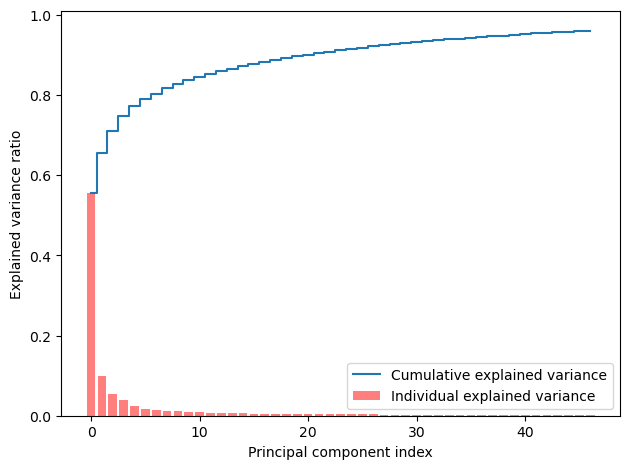

In [7]:
#https://vitalflux.com/pca-explained-variance-concept-python-example/#google_vignette

pca = PCA()
pca = PCA(n_components=.96)
#
# Determine transformed features
#
X_train_pca = pca.fit_transform(train_set)
#
# Determine explained variance using explained_variance_ration_ attribute
#
exp_var_pca = pca.explained_variance_ratio_
#
# Cumulative sum of eigenvalues; This will be used to create step plot
# for visualizing the variance explained by each principal component.
#
cum_sum_eigenvalues = np.cumsum(exp_var_pca)
#
# Create the visualization plot
#
plt.bar(range(0,len(exp_var_pca)), exp_var_pca, alpha=0.5, align='center', color='r',label='Individual explained variance')
plt.step(range(0,len(cum_sum_eigenvalues)), cum_sum_eigenvalues, where='mid',label='Cumulative explained variance')
plt.ylabel('Explained variance ratio')
plt.xlabel('Principal component index')
plt.legend(loc='best')
plt.tight_layout()
plt.show()

In [8]:
# https://www.datacamp.com/tutorial/principal-component-analysis-in-python

def encode_pca(dataset):
    pca_x_test = PCA(n_components=32)
    principalComponents_x_test = pca_x_test.fit_transform(dataset)
    if isinstance(dataset,np.ndarray):
        index = None
    else:
        index=dataset.index
    pca_x_test_ds = pd.DataFrame(data = principalComponents_x_test, 
                                       index=index)
    return pca_x_test_ds, pca_x_test

full_pca_dataset, pca_x = encode_pca(full_ds)
split_pt = int(0.7 * len(full_pca_dataset))
pca_test_dataset = full_pca_dataset[split_pt:]
pca_train_dataset = full_pca_dataset[:split_pt]

In [9]:
pca_train_dataset

,0,1,2,3,4,5,6,7,8,9,...,22,23,24,25,26,27,28,29,30,31
Patient_ID,,,,,,,,,,,,,,,,,,,,,
55_control,-1.400480,0.036085,0.633785,0.991954,1.244477,1.137486,0.029610,0.658527,1.078466,-0.619487,...,0.470832,0.133802,-0.203272,-0.410425,0.186449,0.298332,-0.400682,0.767596,0.619227,0.085812
168_CD_plain,0.343929,-0.897671,0.955659,-0.201677,0.422730,-0.572408,0.003687,0.056367,0.171045,0.062771,...,0.027877,-0.336420,-0.175358,0.370251,-0.039556,0.055334,0.058026,0.161180,0.149297,-0.265662
72_control,-2.307192,-0.267483,1.578081,0.496850,-0.234867,0.234571,0.184197,0.036992,-0.068803,-0.119890,...,0.183052,0.194263,0.234877,0.178692,0.362024,-0.116276,-0.019640,-0.014161,0.195361,-0.416527
120_control,0.352933,-1.007575,-0.545913,0.208984,-0.308962,-0.011900,-0.357425,0.045246,-0.176911,-0.057539,...,0.046615,0.026036,-0.092182,0.198564,0.214210,-0.068817,0.149709,-0.144454,-0.024551,-0.078279
258_CD_plain,-1.060160,-0.005791,-0.675548,0.336661,-0.086003,0.094171,-0.527973,-0.092358,0.061105,0.117648,...,-0.081974,-0.346245,0.006149,0.066966,-0.062242,0.032586,0.045676,0.160777,-0.083701,-0.201276
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15_CD_plain,0.518700,2.631580,0.914480,-1.113737,-0.453870,-0.297425,0.328632,0.365649,0.381446,0.426910,...,-0.247678,-0.078042,0.051630,-0.065564,0.249531,-0.063245,0.432105,-0.029305,0.191425,-0.047575
182_CD_plain,0.876848,-0.873024,-0.229033,-0.623545,0.243320,0.249689,0.376666,-0.193785,-0.063964,-0.053892,...,0.198387,0.005078,0.106484,-0.248362,-0.114181,-0.104506,-0.110896,-0.119660,0.091979,0.218882
164_CD_plain,-1.977341,1.297043,-0.604174,0.409995,0.269979,0.258461,-0.132664,-0.176443,-0.008317,0.210307,...,-0.170181,0.229245,-0.190584,0.244012,0.039333,-0.238115,-0.067049,0.050171,0.149764,0.065102


In [10]:
# pca_train_dataset.to_csv("pca_train_dataset.csv")

In [11]:
print('Explained variation per principal component: {}'.format(pca_x.explained_variance_ratio_))
print("Total variance explained:",np.sum(pca_x.explained_variance_ratio_))

Explained variation per principal component: [0.56341432 0.09078083 0.05353027 0.03828962 0.02544877 0.01561396
 0.01497484 0.01148111 0.00990578 0.00885767 0.0079122  0.00719717
 0.0069242  0.00666156 0.00566338 0.00530329 0.00482758 0.00458454
 0.00434476 0.00417284 0.00393261 0.00377049 0.00365348 0.00344381
 0.00332665 0.00316007 0.00306275 0.0028374  0.00266067 0.00265178
 0.0025068  0.00232299]
Total variance explained: 0.927218204658128


In [12]:
# pc1_var, pc2_var = np.round(pca_x_test.explained_variance_ratio_ * 100, 1)
# pc1_var

### Dimensionality reduction with autoencoder

In [13]:
def load_encoder():
    n_inputs = 219
    n_bottleneck = 32
    encoder = Sequential(
                [

    #                 Input(shape=(n_inputs,)),
                    # encoder level 1
                    Dense(n_inputs*2),
                    BatchNormalization(),
                    LeakyReLU(),
                    # encoder level 2
                    Dense(n_inputs),
                    BatchNormalization(),
                    LeakyReLU(),
                    # bottleneck
                    Dense(n_bottleneck)
                ]
            )

    sh = test_set.head(1).shape
    encoder.load_weights("encoder_ckpt")
    encoder.build(sh) 
#     encoder.summary()
    return encoder

In [14]:
def ae_encode_dataset(dataset):
    encoder = load_encoder()
    latent_var = np.arange(32)
#     print(type(dataset))
    if isinstance(dataset,np.ndarray):
        recon = encoder(dataset)
        index=None
    else:
        recon = encoder(dataset.values)
        index = dataset.index
    r = pd.DataFrame(recon, columns=latent_var, index=index)
    return r
    
full_ae_dataset = ae_encode_dataset(full_ds)

split_pt = int(0.7 * len(full_ae_dataset))
ae_test_dataset = full_ae_dataset[split_pt:]
ae_train_dataset = full_ae_dataset[:split_pt]

In [15]:
ae_train_dataset

,0,1,2,3,4,5,6,7,8,9,...,22,23,24,25,26,27,28,29,30,31
Patient_ID,,,,,,,,,,,,,,,,,,,,,
55_control,2.884348,-4.333632,1.534629,0.357453,0.831423,-0.201379,-0.335116,1.899084,-1.299261,-0.198478,...,2.173890,0.097263,0.444464,0.296948,1.785042,-0.130478,1.609985,2.002768,0.458599,0.722745
168_CD_plain,1.049997,0.968498,-0.634117,-1.679890,1.635449,-2.056087,-0.223816,1.611414,-0.198338,-1.088065,...,0.259527,-1.898594,-0.041199,-1.653017,-2.995473,-1.641031,-1.288697,0.736618,1.602979,-2.933374
72_control,1.775126,-4.049808,1.087583,1.459852,1.401432,0.852619,2.032758,0.495711,-0.845361,-0.557329,...,0.797558,1.375275,0.568535,2.058962,5.145083,-0.905856,0.867203,3.922681,3.519151,5.548365
120_control,0.117591,0.435450,-0.473291,-1.583053,0.799566,-2.394346,-0.706611,0.784904,0.150020,-2.133907,...,-0.543700,-0.798991,-0.046313,-1.795849,-3.107322,-0.769194,-2.614375,1.161695,0.380128,-3.846728
258_CD_plain,0.443390,-0.772829,0.884035,-0.374245,-0.443627,0.055477,-0.811601,0.414232,-0.582810,-0.579333,...,-0.419681,1.280246,0.369904,-0.106852,2.210283,-1.252376,0.158098,1.858046,0.539129,0.515659
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15_CD_plain,-3.672475,0.834738,1.542264,2.185633,-1.834641,3.122175,-1.350632,-2.351135,0.525460,3.629492,...,0.510670,-0.614047,2.294713,4.817264,1.498689,3.247430,3.975865,-4.355250,-1.201291,4.786653
182_CD_plain,-0.037418,1.366161,-0.056551,-1.735336,0.798326,-1.246346,-0.713014,0.526173,0.040249,-0.985651,...,0.190898,-0.660282,-0.221193,-1.727492,-3.602331,0.124196,-1.659816,-0.023671,-0.760651,-3.536419
164_CD_plain,0.310530,-2.311946,2.365372,1.838397,-1.330654,1.877666,-0.140262,-0.564555,-1.049672,0.395509,...,0.349844,2.943312,1.415317,2.549941,6.379101,-1.128445,1.433520,1.920403,0.837956,5.438933


## True labels

In [16]:
train_patient_ids = np.array(pca_train_dataset.index)


In [17]:
test_patient_ids = np.array(pca_test_dataset.index)


In [18]:
def classify(x):
    if "_control" in x: # control
        return 0
    elif "CD_plain" in x: # Crohn's Disease no deep ulcer
#         print(x)
        return 1
    elif "CD_deep_ulcer" in x: # Crohn's Disease deep ulcer
#         print(x)
        return 2
    else:
        return 3 # Ulcerative Collitis

vec = np.vectorize(classify)

train_disease_labels = vec(train_patient_ids)
test_disease_labels = vec(test_patient_ids)

In [19]:
import matplotlib.pyplot as plt

from matplotlib.ticker import NullFormatter
from sklearn import manifold, datasets
from time import time

## KMeans clustering

### Training

In [20]:
def train_kmeans(full_dataset, perplexity):
    # compress to 2D with tSNE
    tsne = manifold.TSNE(
        n_components=2,
        init="random",
        random_state=0,
        perplexity=perplexity,
        n_iter=750,
        method='exact'
    )
    X = tsne.fit_transform(full_dataset)
    X_test = X[split_pt:]
    X_train = X[:split_pt]
    # X_train = np.concatenate([X[:split_pt], X[-num_c:]])

    num_c=4
    kmeans = KMeans(num_c, random_state=0).fit(X_train)
    k_labels_train = kmeans.predict(X_train)
    k_labels_test = kmeans.predict(X_test)


    # representation of the KMeans model (both)
    # centers = X[-num_c:]
    centers = kmeans.cluster_centers_
    radii = [cdist(X_train[k_labels_train == i], [center]).max()
             for i, center in enumerate(centers)]
    
    return kmeans, X_train, X_test, k_labels_train, k_labels_test, centers, radii

## Process KMeans models

In [21]:
def get_count_matrix_km(kmeans, X_train, train_disease_labels):

    
    # make matrix to record number of each class in each cluster
    amounts = np.zeros((3, num_c))
    
    
    classes = ["control", "CD_no_ulcer", "CD_deep_ulcer"]
    centers = kmeans.cluster_centers_
    for c, cls in enumerate(classes):
        for pt in X_train[train_disease_labels==c]:
            pt = pt.reshape(1,-1)
            distances = cdist(centers, pt, 'euclidean')
            closest_cluster = np.argmin(distances)
            amounts[c][closest_cluster] += 1
    

#     print(amounts)
    #                cluster 0, cluster 1, cluster 2, cluster 3
    # control 
    # CD no ulcer
    # CD deep ulcer
    
    return amounts

In [22]:
def pair_repeat(dup, cls_assignments, num_c, amounts):
    all_clusters = np.arange(num_c)
    # replace one of the duplicates with max of remaining clusters
    replace_class = np.where(cls_assignments == dup[0])[0][0]
    rem_cluster_a, rem_cluster_b = np.setdiff1d(all_clusters,cls_assignments)
    # rem_cluster_b
    if amounts[replace_class][rem_cluster_a] > amounts[replace_class][rem_cluster_b]:
        cls_assignments[replace_class] = rem_cluster_a
    else:
        cls_assignments[replace_class] = rem_cluster_b
        
    return cls_assignments

def handle_duplicates(cls_assignments, dup, c, num_c, amounts):
#     print("c:",c)
    if len(c) != 1:
        
        cls_assignments = pair_repeat(dup, cls_assignments, num_c, amounts)
    else: # 3 repeats of same thing
        # reassign class least associated to next most associated cluster
        given_cluster = dup[0]
        cls_least = np.argmin(amounts[:,given_cluster])
#         print(cls_least)
        class_amounts = amounts[cls_least,:]
        class_amounts[given_cluster] = -1
        next_cluster = np.argmax(class_amounts)
        cls_assignments[cls_least] = next_cluster
#         print("intermediate assignments",cls_assignments)
        
        # handle other duplicate pair
        u, c = np.unique(cls_assignments, return_counts=True)
        dup = u[c > 1]
        cls_assignments = pair_repeat(dup, cls_assignments, num_c, amounts)

    return cls_assignments

In [23]:

    
def process_clusters(amounts, X_train, num_c):
    all_clusters = np.arange(num_c)

    
    cls_assignments = np.argmax(amounts, axis=1) # assigned to class 0, 1, 2
#     print("initial cls assignments:",cls_assignments)
    
    # check for and handle duplicates
    u, c = np.unique(cls_assignments, return_counts=True)
    dup = u[c > 1]
#     print("dup:",dup[0])
    if len(dup) > 0:
        cls_assignments = handle_duplicates(cls_assignments, dup, c, num_c, amounts)
        
            
    class_assignment_amounts = np.max(amounts, axis=1) 
    
    assignments = [None] * 3
    
    assigned = 0
    while assigned < num_c - 1:
        curr_max_class = np.argmax(class_assignment_amounts)
        assigned_cluster = cls_assignments[curr_max_class]
        if assignments[curr_max_class] is None:
            assignments[curr_max_class] = [assigned_cluster]
        else:
            assignments[curr_max_class].append(assigned_cluster)
        class_assignment_amounts[curr_max_class] = -1
        assigned += 1

    # Assign remaining cluster
    
    rem_cluster = np.setdiff1d(all_clusters,cls_assignments)[0]
    
    rem_cls_assignment = np.argmax(amounts[:,rem_cluster], axis=0)
    assignments[rem_cls_assignment].append(rem_cluster)
    couple = assignments[rem_cls_assignment]
    # clusters assigned to disease class 0, 1, 2 (control, CD_no_ulcer, CD_deep_ulcer)
    
#     print(assignments)
#     print(couple)
    return assignments, couple

In [24]:
def get_class_from_label(label, couple, assignments):
    if label in couple:
        search_term = couple
    else:
        search_term = [label]
    try:
        cls = assignments.index(search_term)
    except:
        return None
    return cls


In [25]:
def get_final_clusters(assignments, couple, labels):
    test_set_clusters = []
    for label in labels:
        cls = get_class_from_label(label, couple, assignments)
        test_set_clusters.append(cls)

    test_set_clusters = np.array(test_set_clusters)
    return test_set_clusters

In [26]:
num_c = 4
perplexity = 24
kmeans_ae, X_train_ae, X_test_ae, k_labels_train_ae, k_labels_test_ae, centers_ae, radii_ae = train_kmeans(full_ae_dataset, perplexity)
kmeans_pca, X_train_pca, X_test_pca, k_labels_train_pca, k_labels_test_pca, centers_pca, radii_pca = train_kmeans(full_pca_dataset, perplexity)

C:\Users\shard\anaconda3\envs\mvp4\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\shard\anaconda3\envs\mvp4\lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\Users\shard\anaconda3\envs\mvp4\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\shard\anaconda3\envs\mvp4\lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. Y

### Apply resulting models to test sets

In [27]:
km_labels_list = [k_labels_test_ae, k_labels_test_pca]
km_models_list = [kmeans_ae, kmeans_pca]
train_set_list = [X_train_ae, X_train_pca]
test_set_list = [X_test_ae, X_test_pca]
centers_list = [centers_ae, centers_pca]
radii_list = [radii_ae, radii_pca]


In [28]:
def plot_final_km_models(labels_list, models_list, train_set_list, test_set_list, centers_list, radii_list, num_c, selected_patient_idx=None):

    (fig, subplots) = plt.subplots(1, 2, figsize=(15,6))
    reduction = ["autoencoder", "PCA"]
    final_clusters_lst = []
    for i in range(len(models_list)):
        ax = subplots[i]
        km = models_list[i]
        km_labels = labels_list[i]
        X_train = train_set_list[i]
        X_test = test_set_list[i]
        centers = centers_list[i]
        radii = radii_list[i]
        amounts = get_count_matrix_km(km, X_train, train_disease_labels)
        assignments, couple = process_clusters(amounts, X_train, num_c)
        test_set_clusters = get_final_clusters(assignments, couple, km_labels)
#         print("gmmlabels:",gmm_labels)
#         print("tsclusters:",test_set_clusters)
#         print("asgn:",assignments)
        final_clusters_lst.append(test_set_clusters)




        reduc = reduction[i]
        num_clusters = 3
        cluster_names = ["Control", "CD no ulcer", "CD deep ulcer"]
        colours = ["green", "orange", "red"]
        ax.set_title("KMeans clustering on test set with true labels shown \n (" + reduc + " dimensionality reduction)",
                    wrap=True)

        for i in range(num_clusters):
            ax.scatter(X_test[test_set_clusters==i, 0], X_test[test_set_clusters==i, 1], c=colours[i], label=cluster_names[i], s=40, cmap='viridis', zorder=2) 

        ax.axis('equal')


        for c, r in zip(centers, radii):
            ax.add_patch(plt.Circle(c, r, fc='#CCCCCC', lw=3, alpha=0.5, zorder=1))
            
        ax.legend()

        if selected_patient_idx is not None:
            ax.scatter(X_test[selected_patient_idx, 0], X_test[selected_patient_idx, 1], c="cyan", s=500, marker='*',edgecolor='black', linewidth=.7, label="Selected patient", zorder=2)

    plt.show()


    return final_clusters_lst
        

C:\Users\shard\AppData\Local\Temp\ipykernel_13280\161184728.py:33: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  ax.scatter(X_test[test_set_clusters==i, 0], X_test[test_set_clusters==i, 1], c=colours[i], label=cluster_names[i], s=40, cmap='viridis', zorder=2)


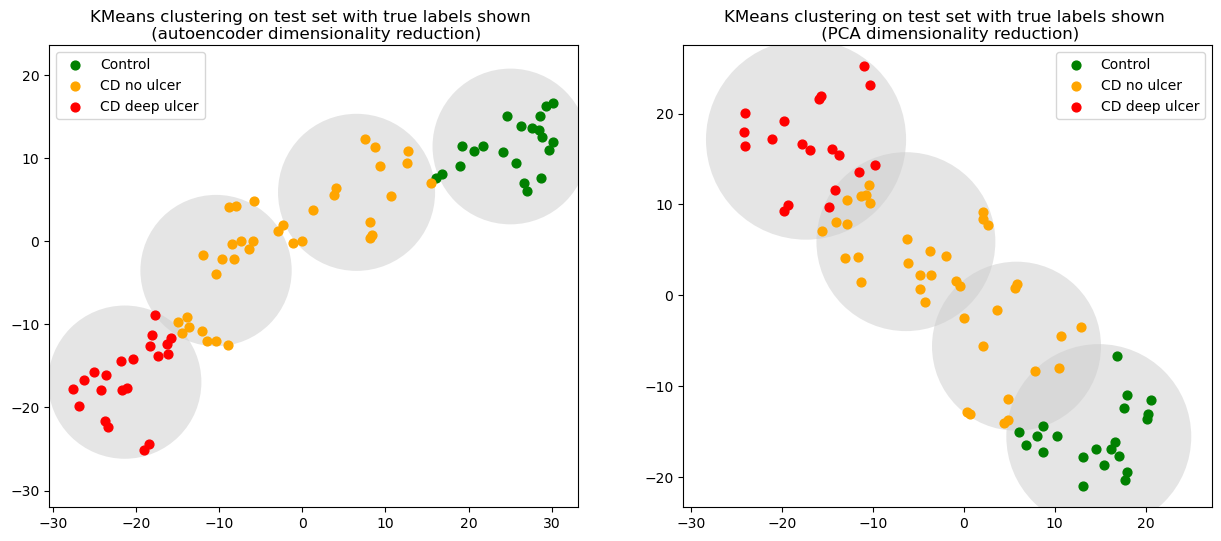

[array([0, 1, 2, 1, 1, 0, 2, 2, 2, 0, 2, 1, 1, 1, 1, 2, 2, 1, 2, 2, 1, 1,
        0, 1, 2, 0, 0, 2, 0, 0, 1, 2, 1, 0, 1, 1, 2, 0, 1, 2, 0, 1, 1, 0,
        0, 1, 1, 0, 1, 1, 1, 2, 1, 0, 2, 0, 0, 0, 1, 2, 1, 1, 0, 2, 2, 2,
        0, 1, 1, 1, 1, 1, 0, 1, 2, 1, 1, 1]),
 array([0, 0, 2, 1, 1, 0, 2, 2, 2, 0, 2, 1, 1, 1, 1, 2, 2, 1, 2, 2, 1, 1,
        0, 1, 2, 0, 0, 2, 0, 0, 1, 1, 1, 0, 1, 1, 2, 0, 1, 2, 0, 1, 1, 0,
        0, 1, 1, 0, 1, 1, 1, 2, 1, 0, 2, 0, 0, 1, 1, 2, 1, 1, 0, 2, 2, 1,
        0, 1, 1, 1, 1, 1, 0, 1, 2, 1, 1, 1])]

In [29]:
plot_final_km_models(km_labels_list, km_models_list, train_set_list, test_set_list, centers_list, radii_list, num_c)

## Gaussian Mixture Models

In [30]:
# https://jakevdp.github.io/PythonDataScienceHandbook/05.12-gaussian-mixtures.html

from matplotlib.patches import Ellipse
from sklearn import mixture

def draw_ellipse(position, covariance, ax=None, **kwargs):
    """Draw an ellipse with a given position and covariance"""
    ax = ax or plt.gca()
    
    # Convert covariance to principal axes
    if covariance.shape == (2, 2):
        U, s, Vt = np.linalg.svd(covariance)
        angle = np.degrees(np.arctan2(U[1, 0], U[0, 0]))
        width, height = 2 * np.sqrt(s)
    else:
        angle = 0
        width, height = 2 * np.sqrt(covariance)
    
    # Draw the Ellipse
    for nsig in range(1, 4):
        ax.add_patch(Ellipse(position, nsig * width, nsig * height,
                             angle, **kwargs))
        


## Process GMM cluster models

In [31]:
num_c = 4

def fit_gmm(full_dataset, perplexity, num_c):
    gmm = mixture.GaussianMixture(n_components=num_c,covariance_type='full', random_state=42)
    tsne = manifold.TSNE(
        n_components=2,
        init="random",
        random_state=0,
        perplexity=24,
        n_iter=750,
        method='exact'
    )
    X = tsne.fit_transform(full_dataset)
    X_test = X[split_pt:]
    X_train = X[:split_pt]
    gmm.fit(X_train)
    
    return gmm, X_train, X_test



In [32]:
import scipy.stats
from scipy.stats import multivariate_normal


In [33]:
def get_amount_matrix_gmm(gmm, X_train, train_disease_labels):
    mu, covar, w = gmm.means_, gmm.covariances_, gmm.weights_
    # print("means:",mu)
    # print("covariances_:",covar)
    # print("weights_:",w)
    
    comps = [multivariate_normal(mu[i], covar[i]) for i in range(num_c)]
    
    # make matrix to record amount of each class in each mixture component
    amounts = np.zeros((3, num_c))
    
    
    classes = ["control", "CD_no_ulcer", "CD_deep_ulcer"]
    for c, cls in enumerate(classes):
        for i, comp in enumerate(comps): # add up contributions for each component
            weight = w[i]
            pts = X_train[train_disease_labels==c]
            curr_sum = np.sum(comp.pdf(pts)) * weight
            amounts[c][i] = curr_sum
#     print(amounts)
    #                cluster 0, cluster 1, cluster 2, cluster 3
    # control 
    # CD no ulcer
    # CD deep ulcer
    
    return amounts

In [34]:
def final_gmm_model_get_clusters(gmm, X_train, X_test, train_disease_labels):
    # process
    amounts = get_amount_matrix_gmm(gmm, X_train, train_disease_labels)
    assignments, couple = process_clusters(amounts, X_train, num_c)
    # retrieve clusters
    gmm_labels = gmm.predict(X_test)
    test_set_clusters = get_final_clusters(assignments, couple, gmm_labels)
    
    return test_set_clusters



### Apply resulting models to test sets

In [35]:
perplexity = 24
gmm_pca, X_train_pca, X_test_pca = fit_gmm(full_pca_dataset, perplexity, num_c)
gmm_ae, X_train_ae, X_test_ae = fit_gmm(full_ae_dataset, perplexity, num_c)

C:\Users\shard\anaconda3\envs\mvp4\lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\Users\shard\anaconda3\envs\mvp4\lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


In [36]:
# gmm_labels_list = [gmm_labels_ae, gmm_labels_pca]
gmm_models_list = [gmm_ae, gmm_pca]
train_set_list = [X_train_ae, X_train_pca]
test_set_list = [X_test_ae, X_test_pca]


In [37]:
X_train_ae.shape

(182, 2)

In [38]:
# X_test_ae

C:\Users\shard\AppData\Local\Temp\ipykernel_13280\3442911059.py:41: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  ax.scatter(X_test[test_set_clusters==i, 0], X_test[test_set_clusters==i, 1], c=colours[i], label=cluster_names[i], s=40, cmap='viridis', zorder=2)
C:\Users\shard\AppData\Local\Temp\ipykernel_13280\3052257362.py:21: MatplotlibDeprecationWarning: Passing the angle parameter of __init__() positionally is deprecated since Matplotlib 3.6; the parameter will become keyword-only two minor releases later.
  ax.add_patch(Ellipse(position, nsig * width, nsig * height,
C:\Users\shard\AppData\Local\Temp\ipykernel_13280\3442911059.py:41: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  ax.scatter(X_test[test_set_clusters==i, 0], X_test[test_set_clusters==i, 1], c=colours[i], label=cluster_names[i], s=40, cmap='viridis', zorder=2)
C:\Users\shard\AppData\Local\Temp\ipykernel_13280\3052257362.py:21: Ma

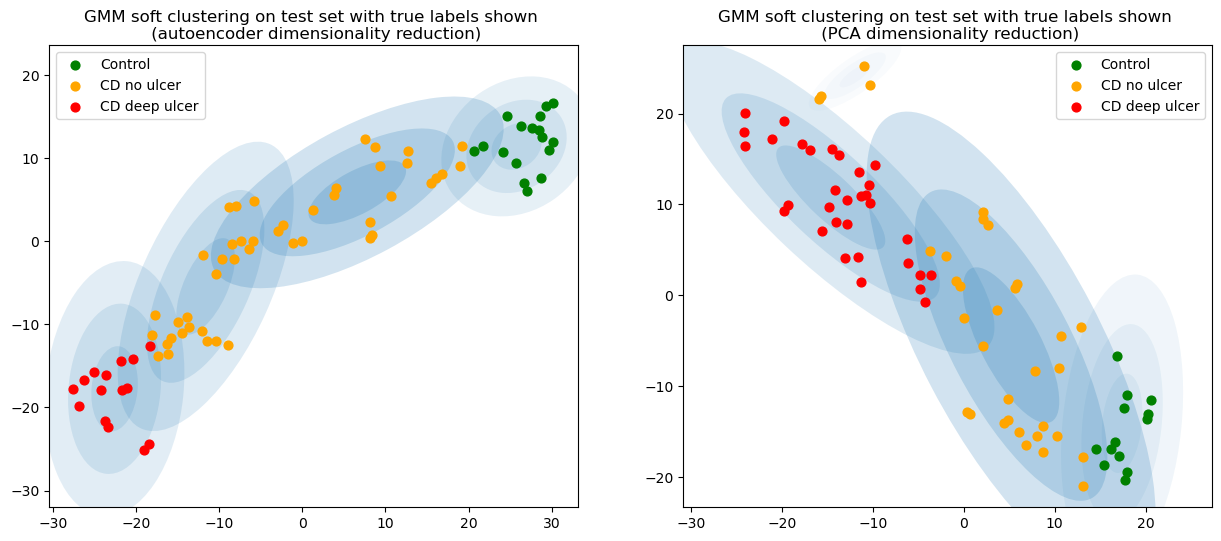

In [39]:
def plot_final_gmm_models(gmm_models_list, train_set_list, test_set_list, num_c, selected_patient_idx=None):
#         left = -8
#         right = 8
#         ax.set_xlim(left, right)
#         ax.set_ylim(left, right)
        
        
#         if i==0:
#             num_clusters = num_c
#             cluster_names = ["Cluster " + str(i) for i in range(num_clusters)]
#             colours = ["chocolate", "darkblue", "magenta", "yellow", "blue"]
#             ax.set_title("GMM soft clustering on " + dset + " set with cluster labels shown \n (" + reduction + " dimensionality reduction)",
#                          wrap=True)
#         else:
#     fig, ax = plt.subplots()
    (fig, subplots) = plt.subplots(1, 2, figsize=(15, 6))
    reduction = ["autoencoder", "PCA"]
    final_clusters_lst = []
    for i in range(len(gmm_models_list)):
#         print(i)
        ax = subplots[i]
        gmm = gmm_models_list[i]
        X_train = train_set_list[i]
        X_test = test_set_list[i]

        test_set_clusters = final_gmm_model_get_clusters(gmm, X_train, X_test, train_disease_labels)

        final_clusters_lst.append(test_set_clusters)




        reduc = reduction[i]
        num_clusters = 3
        cluster_names = ["Control", "CD no ulcer", "CD deep ulcer"]
        colours = ["green", "orange", "red"]
        ax.set_title("GMM soft clustering on test set with true labels shown \n (" + reduc + " dimensionality reduction)",
                    wrap=True)

        for i in range(num_clusters):
            ax.scatter(X_test[test_set_clusters==i, 0], X_test[test_set_clusters==i, 1], c=colours[i], label=cluster_names[i], s=40, cmap='viridis', zorder=2) 

        ax.axis('equal')


        w_factor = 0.2 / gmm.weights_.max()
        for pos, covar, w in zip(gmm.means_, gmm.covariances_, gmm.weights_):
            draw_ellipse(pos, covar, alpha=w * w_factor, ax=ax)
        ax.legend()
        
        if selected_patient_idx is not None:
            ax.scatter(X_test[selected_patient_idx, 0], X_test[selected_patient_idx, 1], c="cyan", s=500, marker='*',edgecolor='black', linewidth=.7, label="Selected patient", zorder=2)

        
    plt.show()


    return final_clusters_lst
        
final_clusters_gmm_ae, final_clusters_gmm_pca = plot_final_gmm_models(gmm_models_list, train_set_list, test_set_list, num_c)

3rd graph - substructure clustering processed in combination with true labels to obtain final 3 cluster clustering; model can now be easily coupled to shap - why better than simple k=3 clustering

# Class contrastive explainability

## Gene expression distributions of test set (post scaling)

In [40]:
hundred_control = x_test_scaled.loc[x_test_scaled.index.str.endswith('_control')]
hundred_CD_plain = x_test_scaled.loc[x_test_scaled.index.str.endswith('_CD_plain')]
hundred_CD_deep_ulcer = x_test_scaled.loc[x_test_scaled.index.str.endswith('_CD_deep_ulcer')]
datasets = [hundred_control, hundred_CD_plain, hundred_CD_deep_ulcer]
labels = ["Control", "Crohn's Disease", "Crohn's Disease Deep Ulcer"]
colours = ["green", "orange", "red"]

In [41]:
# import matplotlib.pyplot as plt
# import scipy.stats as stats
# import math

# for gene_symbol in hundred_control.columns:
#     for i in range(len(datasets)):
#         ds = datasets[i]
#         label = labels[i]
#         colour = colours[i]
#         vals = ds[gene_symbol].values
#         gene_stats = ds.describe()
#         g_mean = gene_stats.loc["mean", gene_symbol]
#         g_std = gene_stats.loc["std", gene_symbol]
#         g_min = gene_stats.loc["min", gene_symbol]
#         g_max = gene_stats.loc["max", gene_symbol]

#         mu = g_mean
#         variance = g_std**2
#         sigma = math.sqrt(variance)
#         x = np.linspace(g_min, g_max, 100)
#         plt.plot(x, stats.norm.pdf(x, mu, sigma), label=label, c=colour)

#         if i<4:
#             plt.hist(vals, bins=25, density=True, alpha=0.6, color=colour)
#     plt.title(gene_symbol+" Distributions")
#     plt.xlabel('Gene expression (FPKM)')
#     plt.ylabel('Probability density')
#     plt.legend()
#     plt.show()

## GMM Explainability - CD Deep Ulcer patient

In [42]:
def get_patient(test_set, symptom, frac=4):
    poss_patients = test_set.loc[test_set.index.str.endswith(symptom)]
#     print(len(poss_patients),"possible")
    selected_patient = poss_patients.iloc[[len(poss_patients)//frac]]
    pid = selected_patient.index[0]
    return selected_patient, pid

selected_patient, pid = get_patient(test_set, 'CD_deep_ulcer')
selected_patient

,AADAC,APOA1,APOA4,APOB,APOC3,AQP9,C6,CEACAM7,CHI3L1,ABCC2,...,TAF15,ZFYVE20,LOC100420253,LY6G5B,C5orf58,RSL24D1P1,MIEN1,PCBP1_AS1,LOC100133165,DNAJB8
Patient_ID,,,,,,,,,,,,,,,,,,,,,
46_CD_deep_ulcer,0.438089,0.482152,0.410237,0.378247,0.438691,0.705762,0.339106,0.559666,0.878088,0.228893,...,0.403676,0.276644,0.0,0.548505,0.391732,0.0,0.243567,0.144529,0.0,0.0


In [43]:
pid

'46_CD_deep_ulcer'

In [44]:
ind = test_set.index
selected_patient_idx = ind.get_loc(pid)
selected_patient_idx

18

C:\Users\shard\AppData\Local\Temp\ipykernel_13280\3442911059.py:41: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  ax.scatter(X_test[test_set_clusters==i, 0], X_test[test_set_clusters==i, 1], c=colours[i], label=cluster_names[i], s=40, cmap='viridis', zorder=2)
C:\Users\shard\AppData\Local\Temp\ipykernel_13280\3052257362.py:21: MatplotlibDeprecationWarning: Passing the angle parameter of __init__() positionally is deprecated since Matplotlib 3.6; the parameter will become keyword-only two minor releases later.
  ax.add_patch(Ellipse(position, nsig * width, nsig * height,
C:\Users\shard\AppData\Local\Temp\ipykernel_13280\3442911059.py:41: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  ax.scatter(X_test[test_set_clusters==i, 0], X_test[test_set_clusters==i, 1], c=colours[i], label=cluster_names[i], s=40, cmap='viridis', zorder=2)
C:\Users\shard\AppData\Local\Temp\ipykernel_13280\3052257362.py:21: Ma

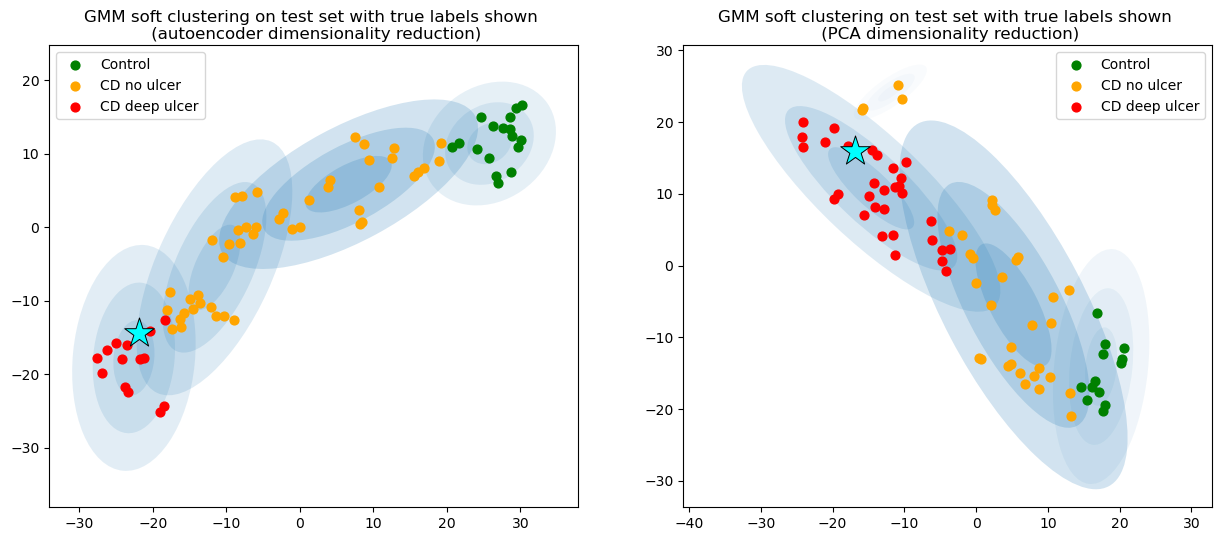

[array([0, 1, 2, 1, 1, 0, 2, 2, 2, 0, 1, 1, 1, 1, 1, 2, 2, 1, 2, 1, 1, 1,
        0, 1, 2, 0, 0, 2, 0, 0, 1, 1, 1, 1, 1, 1, 2, 0, 1, 1, 1, 1, 1, 0,
        1, 1, 1, 0, 1, 1, 1, 2, 1, 0, 2, 0, 0, 1, 1, 2, 1, 1, 0, 2, 1, 1,
        0, 1, 1, 1, 1, 1, 0, 1, 2, 1, 1, 1]),
 array([0, 0, 2, 1, 1, 0, 2, 2, 2, 0, 2, 1, 1, 2, 2, 2, 1, 2, 2, 2, 1, 1,
        0, 1, 1, 0, 0, 1, 0, 0, 1, 2, 2, 1, 1, 2, 2, 0, 2, 2, 1, 1, 1, 0,
        1, 2, 1, 0, 1, 2, 1, 2, 2, 1, 2, 1, 1, 1, 2, 2, 2, 2, 1, 2, 2, 2,
        1, 1, 1, 1, 2, 1, 0, 1, 1, 1, 2, 2])]

In [45]:
plot_final_gmm_models(gmm_models_list, train_set_list, test_set_list, num_c, selected_patient_idx=selected_patient_idx)

### Modify gene expressions for the selected patient - 60 genes

In [46]:
test_set = x_test_scaled.copy()
full_ds = full_ds.copy()

In [47]:
def re_encode(dataset, perplexity, num_c, reduction_type):
    gmm = mixture.GaussianMixture(n_components=num_c,covariance_type='full', random_state=42)
    if reduction_type == "PCA":
        red_dataset, _ = encode_pca(dataset)
    else:
        red_dataset = ae_encode_dataset(dataset)
    tsne = manifold.TSNE(
        n_components=2,
        init="random",
        random_state=0,
        perplexity=24,
        n_iter=750,
        method='exact'
    )
    X = tsne.fit_transform(red_dataset)
    X_test = X[split_pt:]
    X_train = X[:split_pt]
    gmm.fit(X_train)
    
    return gmm, X_train, X_test

In [48]:
with open("most_diff_genes_60", "rb") as fp:   # Unpickling
    most_diff_genes_60 = pickle.load(fp)

In [49]:
def modify_expression(pid, most_diff_genes, dataset):
#     print("dataset size (should be test):",dataset.shape)
    controls = dataset.loc[dataset.index.str.endswith('_control')]
#     plains = x_test_scaled.loc[x_test_scaled.index.str.endswith('_CD_plain')]
#     ulcers = x_test_scaled.loc[x_test_scaled.index.str.endswith('_CD_deep_ulcer')]
    
    for gene_symbol in most_diff_genes:
        new_val = controls.describe().loc["mean", gene_symbol]
        dataset.loc[dataset.index.str.startswith(pid), gene_symbol] = new_val
    return dataset


In [50]:
test_set = modify_expression(pid, most_diff_genes_60, test_set)
test_set.loc[test_set.index.str.startswith(pid)]

,AADAC,APOA1,APOA4,APOB,APOC3,AQP9,C6,CEACAM7,CHI3L1,ABCC2,...,TAF15,ZFYVE20,LOC100420253,LY6G5B,C5orf58,RSL24D1P1,MIEN1,PCBP1_AS1,LOC100133165,DNAJB8
Patient_ID,,,,,,,,,,,,,,,,,,,,,
46_CD_deep_ulcer,0.837271,0.482152,0.800854,0.834515,0.740914,0.705762,0.638968,0.173455,0.313654,0.836045,...,0.403676,0.276644,0.0,0.548505,0.391732,0.0,0.243567,0.144529,0.0,0.0


In [51]:
full_ds[-len(test_set):] = test_set

### Re-encode and refit models

In [52]:
gmm_pca, X_train_pca, X_test_pca = re_encode(full_ds, perplexity, num_c, "PCA")
gmm_ae, X_train_ae, X_test_ae = re_encode(full_ds, perplexity, num_c, "AE")

gmm_models_list = [gmm_ae, gmm_pca]
train_set_list = [X_train_ae, X_train_pca]
test_set_list = [X_test_ae, X_test_pca]

C:\Users\shard\anaconda3\envs\mvp4\lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\Users\shard\anaconda3\envs\mvp4\lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


C:\Users\shard\AppData\Local\Temp\ipykernel_13280\3442911059.py:41: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  ax.scatter(X_test[test_set_clusters==i, 0], X_test[test_set_clusters==i, 1], c=colours[i], label=cluster_names[i], s=40, cmap='viridis', zorder=2)
C:\Users\shard\AppData\Local\Temp\ipykernel_13280\3052257362.py:21: MatplotlibDeprecationWarning: Passing the angle parameter of __init__() positionally is deprecated since Matplotlib 3.6; the parameter will become keyword-only two minor releases later.
  ax.add_patch(Ellipse(position, nsig * width, nsig * height,
C:\Users\shard\AppData\Local\Temp\ipykernel_13280\3442911059.py:41: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  ax.scatter(X_test[test_set_clusters==i, 0], X_test[test_set_clusters==i, 1], c=colours[i], label=cluster_names[i], s=40, cmap='viridis', zorder=2)
C:\Users\shard\AppData\Local\Temp\ipykernel_13280\3052257362.py:21: Ma

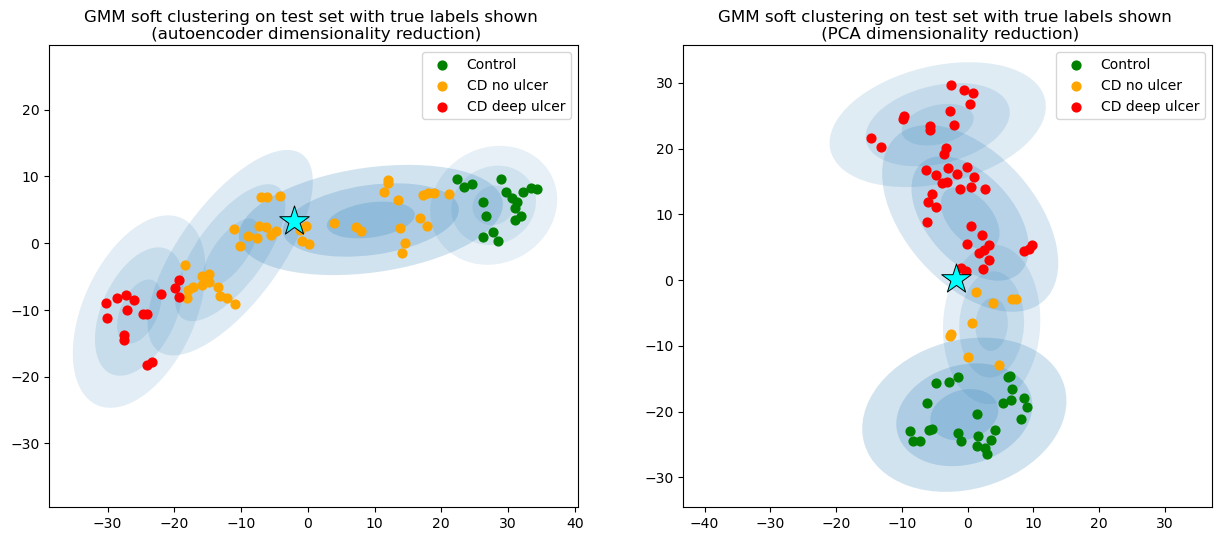

[array([0, 1, 2, 1, 1, 0, 2, 2, 2, 0, 1, 1, 1, 1, 1, 2, 2, 1, 1, 1, 1, 1,
        0, 1, 2, 0, 0, 2, 0, 0, 1, 2, 1, 0, 1, 1, 2, 0, 1, 1, 1, 1, 1, 0,
        1, 1, 1, 0, 1, 1, 1, 2, 1, 0, 2, 0, 0, 1, 1, 2, 1, 1, 0, 2, 2, 1,
        0, 1, 1, 1, 1, 1, 0, 1, 2, 1, 1, 1]),
 array([0, 0, 2, 2, 1, 0, 2, 2, 2, 0, 2, 1, 0, 2, 2, 2, 2, 2, 2, 2, 2, 1,
        0, 1, 2, 0, 0, 2, 0, 0, 1, 2, 2, 0, 0, 2, 2, 0, 2, 2, 0, 2, 2, 0,
        0, 2, 0, 0, 2, 2, 2, 2, 2, 0, 2, 0, 0, 0, 2, 2, 2, 2, 0, 2, 2, 2,
        0, 2, 1, 1, 2, 0, 0, 1, 2, 1, 2, 2])]

In [53]:
plot_final_gmm_models(gmm_models_list, train_set_list, test_set_list, num_c, selected_patient_idx=selected_patient_idx)

### Modify gene expressions for the selected patient - 120 genes

In [54]:
test_set = x_test_scaled.copy()
full_ds = full_ds.copy()

In [55]:
with open("most_diff_genes_115", "rb") as fp:   # Unpickling
    most_diff_genes = pickle.load(fp)

most_diff_genes

['FDCSP', 'FNDC4', 'JKAMP', 'RUFY4']

In [56]:
test_set = modify_expression(pid, most_diff_genes_60, test_set)
test_set.loc[test_set.index.str.startswith(pid)]

,AADAC,APOA1,APOA4,APOB,APOC3,AQP9,C6,CEACAM7,CHI3L1,ABCC2,...,TAF15,ZFYVE20,LOC100420253,LY6G5B,C5orf58,RSL24D1P1,MIEN1,PCBP1_AS1,LOC100133165,DNAJB8
Patient_ID,,,,,,,,,,,,,,,,,,,,,
46_CD_deep_ulcer,0.837271,0.482152,0.800854,0.834515,0.740914,0.705762,0.638968,0.173455,0.313654,0.836045,...,0.403676,0.276644,0.0,0.548505,0.391732,0.0,0.243567,0.144529,0.0,0.0


In [57]:
full_ds[-len(test_set):] = test_set

### Re-encode and refit models

In [58]:
gmm_pca, X_train_pca, X_test_pca = re_encode(full_ds, perplexity, num_c, "PCA")
gmm_ae, X_train_ae, X_test_ae = re_encode(full_ds, perplexity, num_c, "AE")

gmm_models_list = [gmm_ae, gmm_pca]
train_set_list = [X_train_ae, X_train_pca]
test_set_list = [X_test_ae, X_test_pca]

C:\Users\shard\anaconda3\envs\mvp4\lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\Users\shard\anaconda3\envs\mvp4\lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


C:\Users\shard\AppData\Local\Temp\ipykernel_13280\3442911059.py:41: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  ax.scatter(X_test[test_set_clusters==i, 0], X_test[test_set_clusters==i, 1], c=colours[i], label=cluster_names[i], s=40, cmap='viridis', zorder=2)
C:\Users\shard\AppData\Local\Temp\ipykernel_13280\3052257362.py:21: MatplotlibDeprecationWarning: Passing the angle parameter of __init__() positionally is deprecated since Matplotlib 3.6; the parameter will become keyword-only two minor releases later.
  ax.add_patch(Ellipse(position, nsig * width, nsig * height,
C:\Users\shard\AppData\Local\Temp\ipykernel_13280\3442911059.py:41: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  ax.scatter(X_test[test_set_clusters==i, 0], X_test[test_set_clusters==i, 1], c=colours[i], label=cluster_names[i], s=40, cmap='viridis', zorder=2)
C:\Users\shard\AppData\Local\Temp\ipykernel_13280\3052257362.py:21: Ma

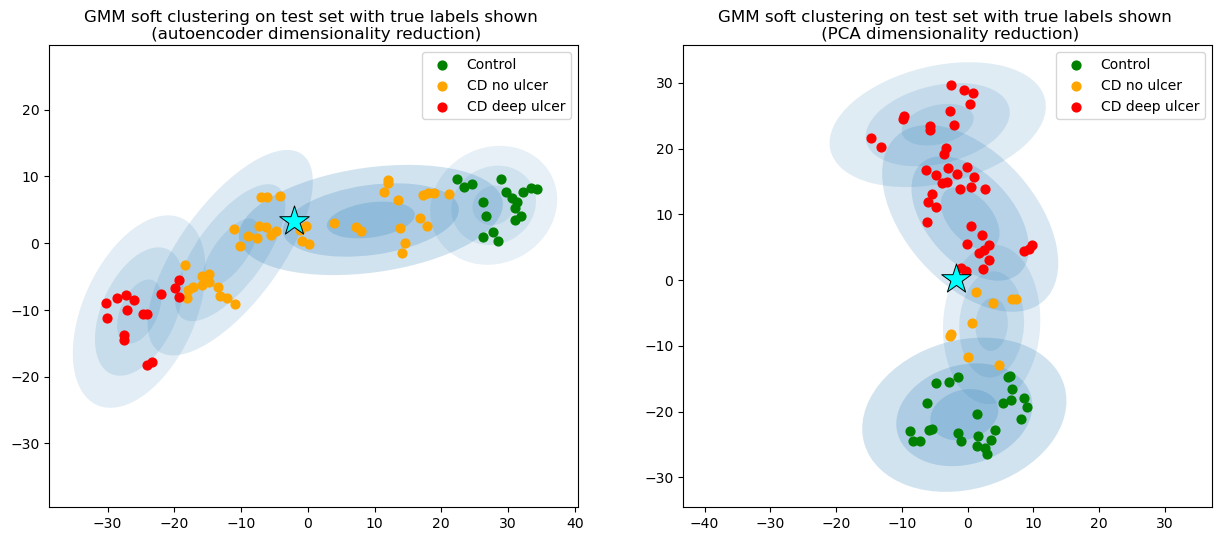

[array([0, 1, 2, 1, 1, 0, 2, 2, 2, 0, 1, 1, 1, 1, 1, 2, 2, 1, 1, 1, 1, 1,
        0, 1, 2, 0, 0, 2, 0, 0, 1, 2, 1, 0, 1, 1, 2, 0, 1, 1, 1, 1, 1, 0,
        1, 1, 1, 0, 1, 1, 1, 2, 1, 0, 2, 0, 0, 1, 1, 2, 1, 1, 0, 2, 2, 1,
        0, 1, 1, 1, 1, 1, 0, 1, 2, 1, 1, 1]),
 array([0, 0, 2, 2, 1, 0, 2, 2, 2, 0, 2, 1, 0, 2, 2, 2, 2, 2, 2, 2, 2, 1,
        0, 1, 2, 0, 0, 2, 0, 0, 1, 2, 2, 0, 0, 2, 2, 0, 2, 2, 0, 2, 2, 0,
        0, 2, 0, 0, 2, 2, 2, 2, 2, 0, 2, 0, 0, 0, 2, 2, 2, 2, 0, 2, 2, 2,
        0, 2, 1, 1, 2, 0, 0, 1, 2, 1, 2, 2])]

In [59]:
plot_final_gmm_models(gmm_models_list, train_set_list, test_set_list, num_c, selected_patient_idx=selected_patient_idx)

## GMM Explainability - CD No Ulcer patient

In [60]:
test_set = x_test_scaled.copy()
full_ds = full_ds.copy()

In [61]:


selected_patient, pid = get_patient(test_set, 'CD_plain', frac=6)
selected_patient

,AADAC,APOA1,APOA4,APOB,APOC3,AQP9,C6,CEACAM7,CHI3L1,ABCC2,...,TAF15,ZFYVE20,LOC100420253,LY6G5B,C5orf58,RSL24D1P1,MIEN1,PCBP1_AS1,LOC100133165,DNAJB8
Patient_ID,,,,,,,,,,,,,,,,,,,,,
58_CD_plain,0.712765,0.67885,0.86582,0.855696,0.828452,0.498697,0.567772,0.352862,0.317254,0.76505,...,0.211571,0.283032,0.0,0.703328,0.556984,0.0,0.415272,0.225017,0.0,0.0


In [62]:
pid

'58_CD_plain'

In [63]:
ind = test_set.index
selected_patient_idx = ind.get_loc(pid)
selected_patient_idx

11

C:\Users\shard\AppData\Local\Temp\ipykernel_13280\3442911059.py:41: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  ax.scatter(X_test[test_set_clusters==i, 0], X_test[test_set_clusters==i, 1], c=colours[i], label=cluster_names[i], s=40, cmap='viridis', zorder=2)
C:\Users\shard\AppData\Local\Temp\ipykernel_13280\3052257362.py:21: MatplotlibDeprecationWarning: Passing the angle parameter of __init__() positionally is deprecated since Matplotlib 3.6; the parameter will become keyword-only two minor releases later.
  ax.add_patch(Ellipse(position, nsig * width, nsig * height,
C:\Users\shard\AppData\Local\Temp\ipykernel_13280\3442911059.py:41: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  ax.scatter(X_test[test_set_clusters==i, 0], X_test[test_set_clusters==i, 1], c=colours[i], label=cluster_names[i], s=40, cmap='viridis', zorder=2)
C:\Users\shard\AppData\Local\Temp\ipykernel_13280\3052257362.py:21: Ma

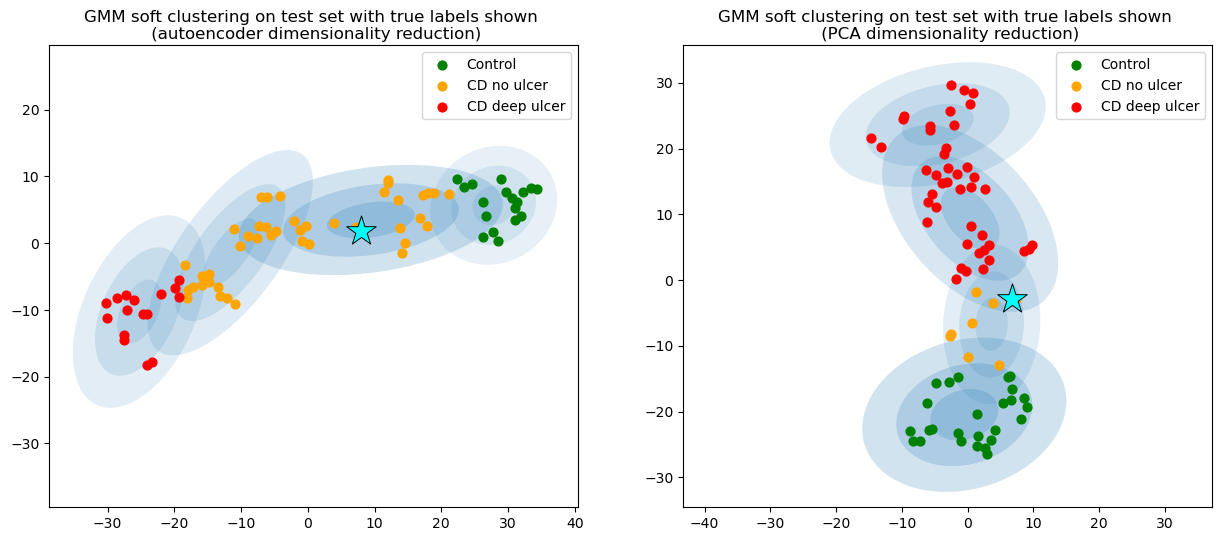

[array([0, 1, 2, 1, 1, 0, 2, 2, 2, 0, 1, 1, 1, 1, 1, 2, 2, 1, 1, 1, 1, 1,
        0, 1, 2, 0, 0, 2, 0, 0, 1, 2, 1, 0, 1, 1, 2, 0, 1, 1, 1, 1, 1, 0,
        1, 1, 1, 0, 1, 1, 1, 2, 1, 0, 2, 0, 0, 1, 1, 2, 1, 1, 0, 2, 2, 1,
        0, 1, 1, 1, 1, 1, 0, 1, 2, 1, 1, 1]),
 array([0, 0, 2, 2, 1, 0, 2, 2, 2, 0, 2, 1, 0, 2, 2, 2, 2, 2, 2, 2, 2, 1,
        0, 1, 2, 0, 0, 2, 0, 0, 1, 2, 2, 0, 0, 2, 2, 0, 2, 2, 0, 2, 2, 0,
        0, 2, 0, 0, 2, 2, 2, 2, 2, 0, 2, 0, 0, 0, 2, 2, 2, 2, 0, 2, 2, 2,
        0, 2, 1, 1, 2, 0, 0, 1, 2, 1, 2, 2])]

In [64]:
plot_final_gmm_models(gmm_models_list, train_set_list, test_set_list, num_c, selected_patient_idx=selected_patient_idx)

### Modify gene expressions for the selected patient - 60 genes

In [65]:
test_set = x_test_scaled.copy()
full_ds = full_ds.copy()

In [66]:
with open("most_diff_genes_60", "rb") as fp:   # Unpickling
    most_diff_genes_60 = pickle.load(fp)

In [67]:
test_set = modify_expression(pid, most_diff_genes_60, test_set)
test_set.loc[test_set.index.str.startswith(pid)]

,AADAC,APOA1,APOA4,APOB,APOC3,AQP9,C6,CEACAM7,CHI3L1,ABCC2,...,TAF15,ZFYVE20,LOC100420253,LY6G5B,C5orf58,RSL24D1P1,MIEN1,PCBP1_AS1,LOC100133165,DNAJB8
Patient_ID,,,,,,,,,,,,,,,,,,,,,
58_CD_plain,0.837271,0.67885,0.800854,0.834515,0.740914,0.498697,0.638968,0.173455,0.313654,0.836045,...,0.211571,0.283032,0.0,0.703328,0.556984,0.0,0.415272,0.225017,0.0,0.0


In [68]:
full_ds[-len(test_set):] = test_set

### Re-encode and refit models

In [69]:
gmm_pca, X_train_pca, X_test_pca = re_encode(full_ds, perplexity, num_c, "PCA")
gmm_ae, X_train_ae, X_test_ae = re_encode(full_ds, perplexity, num_c, "AE")

gmm_models_list = [gmm_ae, gmm_pca]
train_set_list = [X_train_ae, X_train_pca]
test_set_list = [X_test_ae, X_test_pca]

C:\Users\shard\anaconda3\envs\mvp4\lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\Users\shard\anaconda3\envs\mvp4\lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


C:\Users\shard\AppData\Local\Temp\ipykernel_13280\3442911059.py:41: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  ax.scatter(X_test[test_set_clusters==i, 0], X_test[test_set_clusters==i, 1], c=colours[i], label=cluster_names[i], s=40, cmap='viridis', zorder=2)
C:\Users\shard\AppData\Local\Temp\ipykernel_13280\3052257362.py:21: MatplotlibDeprecationWarning: Passing the angle parameter of __init__() positionally is deprecated since Matplotlib 3.6; the parameter will become keyword-only two minor releases later.
  ax.add_patch(Ellipse(position, nsig * width, nsig * height,
C:\Users\shard\AppData\Local\Temp\ipykernel_13280\3442911059.py:41: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  ax.scatter(X_test[test_set_clusters==i, 0], X_test[test_set_clusters==i, 1], c=colours[i], label=cluster_names[i], s=40, cmap='viridis', zorder=2)
C:\Users\shard\AppData\Local\Temp\ipykernel_13280\3052257362.py:21: Ma

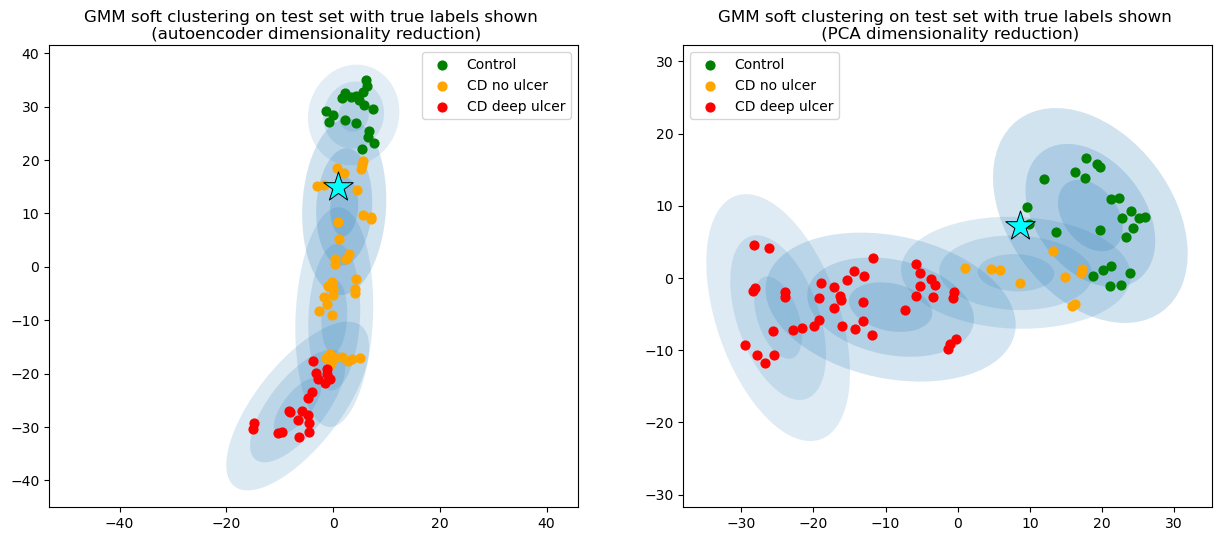

[array([0, 1, 2, 1, 1, 0, 2, 2, 2, 0, 2, 1, 1, 1, 1, 2, 2, 1, 2, 2, 1, 1,
        0, 1, 2, 0, 0, 2, 0, 0, 1, 2, 1, 0, 1, 1, 2, 0, 1, 2, 1, 1, 1, 0,
        0, 1, 1, 0, 1, 1, 1, 2, 1, 0, 2, 0, 0, 1, 1, 2, 1, 1, 0, 2, 2, 2,
        0, 1, 1, 1, 1, 1, 0, 1, 2, 1, 1, 1]),
 array([0, 0, 2, 2, 1, 0, 2, 2, 2, 0, 2, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 1,
        0, 1, 2, 0, 0, 2, 0, 0, 1, 2, 2, 0, 0, 2, 2, 0, 2, 2, 0, 2, 2, 0,
        0, 2, 0, 0, 2, 2, 2, 2, 2, 0, 2, 0, 0, 1, 2, 2, 2, 2, 0, 2, 2, 2,
        0, 2, 1, 1, 2, 0, 0, 1, 2, 1, 2, 2])]

In [70]:
plot_final_gmm_models(gmm_models_list, train_set_list, test_set_list, num_c, selected_patient_idx=selected_patient_idx)

### Modify gene expressions for the selected patient - 120 genes

In [71]:
test_set = x_test_scaled.copy()
full_ds = full_ds.copy()

In [72]:
with open("most_diff_genes_115", "rb") as fp:   # Unpickling
    most_diff_genes = pickle.load(fp)

most_diff_genes

['FDCSP', 'FNDC4', 'JKAMP', 'RUFY4']

In [73]:
test_set = modify_expression(pid, most_diff_genes, test_set)
test_set.loc[test_set.index.str.startswith(pid)]

,AADAC,APOA1,APOA4,APOB,APOC3,AQP9,C6,CEACAM7,CHI3L1,ABCC2,...,TAF15,ZFYVE20,LOC100420253,LY6G5B,C5orf58,RSL24D1P1,MIEN1,PCBP1_AS1,LOC100133165,DNAJB8
Patient_ID,,,,,,,,,,,,,,,,,,,,,
58_CD_plain,0.712765,0.67885,0.86582,0.855696,0.828452,0.498697,0.567772,0.352862,0.317254,0.76505,...,0.211571,0.283032,0.0,0.703328,0.556984,0.0,0.415272,0.225017,0.0,0.0


In [74]:
full_ds[-len(test_set):] = test_set

### Re-encode and refit models

In [75]:
gmm_pca, X_train_pca, X_test_pca = re_encode(full_ds, perplexity, num_c, "PCA")
gmm_ae, X_train_ae, X_test_ae = re_encode(full_ds, perplexity, num_c, "AE")

gmm_models_list = [gmm_ae, gmm_pca]
train_set_list = [X_train_ae, X_train_pca]
test_set_list = [X_test_ae, X_test_pca]

C:\Users\shard\anaconda3\envs\mvp4\lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\Users\shard\anaconda3\envs\mvp4\lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


C:\Users\shard\AppData\Local\Temp\ipykernel_13280\3442911059.py:41: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  ax.scatter(X_test[test_set_clusters==i, 0], X_test[test_set_clusters==i, 1], c=colours[i], label=cluster_names[i], s=40, cmap='viridis', zorder=2)
C:\Users\shard\AppData\Local\Temp\ipykernel_13280\3052257362.py:21: MatplotlibDeprecationWarning: Passing the angle parameter of __init__() positionally is deprecated since Matplotlib 3.6; the parameter will become keyword-only two minor releases later.
  ax.add_patch(Ellipse(position, nsig * width, nsig * height,
C:\Users\shard\AppData\Local\Temp\ipykernel_13280\3442911059.py:41: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  ax.scatter(X_test[test_set_clusters==i, 0], X_test[test_set_clusters==i, 1], c=colours[i], label=cluster_names[i], s=40, cmap='viridis', zorder=2)
C:\Users\shard\AppData\Local\Temp\ipykernel_13280\3052257362.py:21: Ma

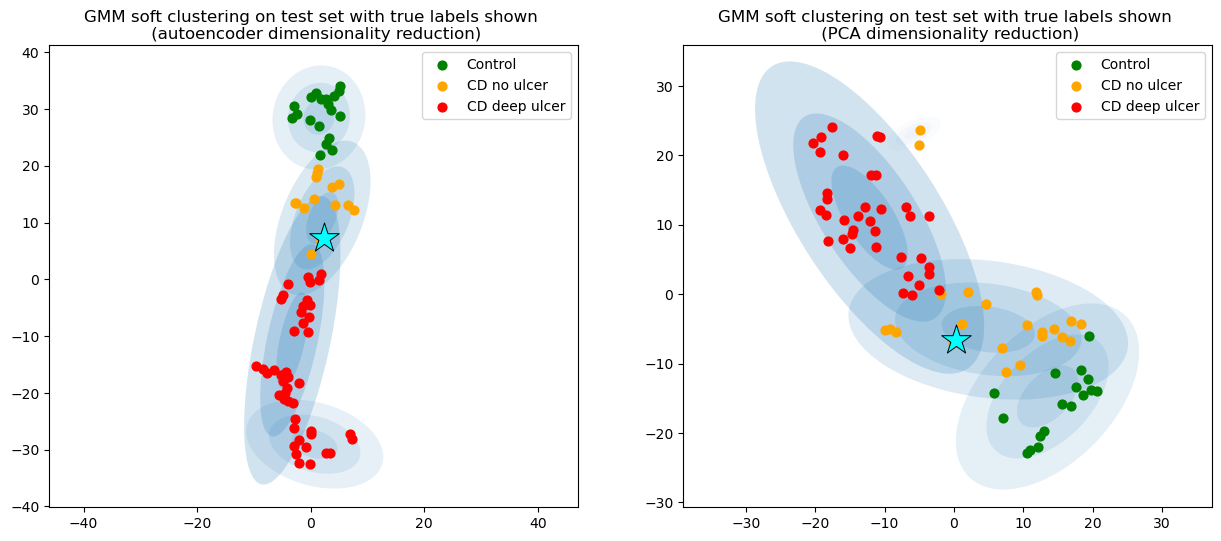

[array([0, 1, 2, 2, 1, 0, 2, 2, 2, 0, 2, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2,
        0, 1, 2, 0, 0, 2, 0, 0, 1, 2, 2, 0, 1, 2, 2, 0, 2, 2, 1, 2, 2, 0,
        0, 2, 1, 0, 2, 2, 2, 2, 2, 0, 2, 0, 0, 1, 2, 2, 2, 2, 0, 2, 2, 2,
        0, 2, 1, 1, 2, 1, 0, 1, 2, 1, 2, 2]),
 array([0, 0, 2, 1, 1, 0, 2, 2, 2, 0, 2, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 1,
        0, 1, 1, 0, 0, 1, 0, 0, 1, 2, 2, 1, 1, 2, 2, 0, 2, 2, 1, 2, 1, 0,
        1, 2, 1, 0, 1, 2, 2, 2, 2, 1, 2, 0, 0, 1, 2, 2, 2, 2, 0, 2, 2, 2,
        1, 1, 1, 1, 2, 0, 0, 1, 2, 1, 2, 2])]

In [76]:
plot_final_gmm_models(gmm_models_list, train_set_list, test_set_list, num_c, selected_patient_idx=selected_patient_idx)

## KMeans Explainability - CD Deep Ulcer patient

In [113]:
def re_encode_km(dataset, perplexity, num_c, reduction_type):
    if reduction_type == "PCA":
        red_dataset, _ = encode_pca(dataset)
    else:
        red_dataset = ae_encode_dataset(dataset)
    tsne = manifold.TSNE(
        n_components=2,
        init="random",
        random_state=0,
        perplexity=24,
        n_iter=750,
        method='exact'
    )
    X = tsne.fit_transform(red_dataset)
    X_test = X[split_pt:]
    X_train = X[:split_pt]
    
    num_c=4
    kmeans = KMeans(num_c, random_state=0).fit(X_train)
    k_labels_train = kmeans.predict(X_train)
    k_labels_test = kmeans.predict(X_test)


    # representation of the KMeans model (both)
    # centers = X[-num_c:]
    centers = kmeans.cluster_centers_
    radii = [cdist(X_train[k_labels_train == i], [center]).max()
             for i, center in enumerate(centers)]
    
    return kmeans, X_train, X_test, k_labels_train, k_labels_test, centers, radii

In [114]:
test_set = x_test_scaled.copy()
full_ds = full_ds.copy()

### Encode and fit models

In [115]:
# gmm_pca, X_train_pca, X_test_pca = re_encode(full_ds, perplexity, num_c, "PCA")
# gmm_ae, X_train_ae, X_test_ae = re_encode(full_ds, perplexity, num_c, "AE")

# gmm_models_list = [gmm_ae, gmm_pca]
# train_set_list = [X_train_ae, X_train_pca]
# test_set_list = [X_test_ae, X_test_pca]

kmeans_pca, X_train_pca, X_test_pca, _, k_labels_test_pca, centers_pca, radii_pca = re_encode_km(full_ds, perplexity, num_c, "PCA")
kmeans_ae, X_train_ae, X_test_ae, _, k_labels_test_ae, centers_ae, radii_ae = re_encode_km(full_ds, perplexity, num_c, "AE")

km_labels_list = [k_labels_test_ae, k_labels_test_pca]
km_models_list = [kmeans_ae, kmeans_pca]
train_set_list = [X_train_ae, X_train_pca]
test_set_list = [X_test_ae, X_test_pca]
centers_list = [centers_ae, centers_pca]
radii_list = [radii_ae, radii_pca]

C:\Users\shard\anaconda3\envs\mvp4\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\shard\anaconda3\envs\mvp4\lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\Users\shard\anaconda3\envs\mvp4\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\shard\anaconda3\envs\mvp4\lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. Y

### Select patient

In [116]:


selected_patient, pid = get_patient(test_set, 'CD_deep_ulcer', frac=4)
selected_patient

,AADAC,APOA1,APOA4,APOB,APOC3,AQP9,C6,CEACAM7,CHI3L1,ABCC2,...,TAF15,ZFYVE20,LOC100420253,LY6G5B,C5orf58,RSL24D1P1,MIEN1,PCBP1_AS1,LOC100133165,DNAJB8
Patient_ID,,,,,,,,,,,,,,,,,,,,,
46_CD_deep_ulcer,0.438089,0.482152,0.410237,0.378247,0.438691,0.705762,0.339106,0.559666,0.878088,0.228893,...,0.403676,0.276644,0.0,0.548505,0.391732,0.0,0.243567,0.144529,0.0,0.0


In [117]:
ind = test_set.index
selected_patient_idx = ind.get_loc(pid)
selected_patient_idx

18

C:\Users\shard\AppData\Local\Temp\ipykernel_13280\161184728.py:33: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  ax.scatter(X_test[test_set_clusters==i, 0], X_test[test_set_clusters==i, 1], c=colours[i], label=cluster_names[i], s=40, cmap='viridis', zorder=2)


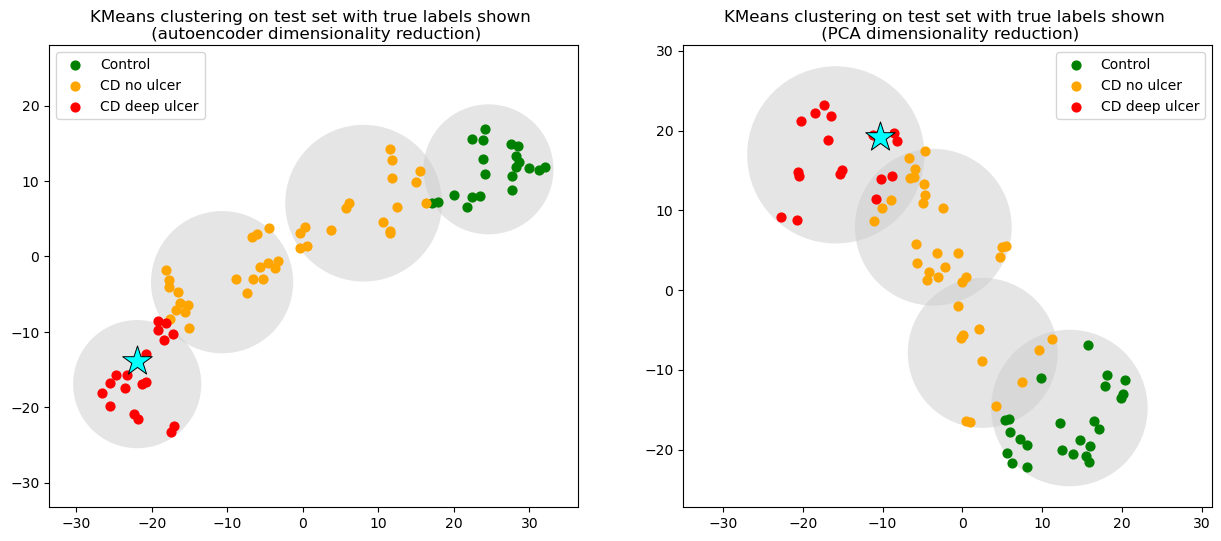

In [118]:
_, _ = plot_final_km_models(km_labels_list, km_models_list, train_set_list, test_set_list, centers_list, radii_list, num_c, selected_patient_idx=selected_patient_idx)

### Modify gene expressions for the selected patient - 60 genes

In [119]:
test_set = x_test_scaled.copy()
full_ds = full_ds.copy()

In [120]:
with open("most_diff_genes_60", "rb") as fp:   # Unpickling
    most_diff_genes_60 = pickle.load(fp)

most_diff_genes

['FDCSP', 'FNDC4', 'JKAMP', 'RUFY4']

In [121]:
test_set = modify_expression(pid, most_diff_genes_60, test_set)
test_set.loc[test_set.index.str.startswith(pid)]

,AADAC,APOA1,APOA4,APOB,APOC3,AQP9,C6,CEACAM7,CHI3L1,ABCC2,...,TAF15,ZFYVE20,LOC100420253,LY6G5B,C5orf58,RSL24D1P1,MIEN1,PCBP1_AS1,LOC100133165,DNAJB8
Patient_ID,,,,,,,,,,,,,,,,,,,,,
46_CD_deep_ulcer,0.837271,0.482152,0.800854,0.834515,0.740914,0.705762,0.638968,0.173455,0.313654,0.836045,...,0.403676,0.276644,0.0,0.548505,0.391732,0.0,0.243567,0.144529,0.0,0.0


In [122]:
full_ds[-len(test_set):] = test_set

### Re-encode and refit models

In [123]:
# gmm_pca, X_train_pca, X_test_pca = re_encode(full_ds, perplexity, num_c, "PCA")
# gmm_ae, X_train_ae, X_test_ae = re_encode(full_ds, perplexity, num_c, "AE")

# gmm_models_list = [gmm_ae, gmm_pca]
# train_set_list = [X_train_ae, X_train_pca]
# test_set_list = [X_test_ae, X_test_pca]

kmeans_pca, X_train_pca, X_test_pca, _, k_labels_test_pca, centers_pca, radii_pca = re_encode_km(full_ds, perplexity, num_c, "PCA")
kmeans_ae, X_train_ae, X_test_ae, _, k_labels_test_ae, centers_ae, radii_ae = re_encode_km(full_ds, perplexity, num_c, "AE")

km_labels_list = [k_labels_test_ae, k_labels_test_pca]
km_models_list = [kmeans_ae, kmeans_pca]
train_set_list = [X_train_ae, X_train_pca]
test_set_list = [X_test_ae, X_test_pca]
centers_list = [centers_ae, centers_pca]
radii_list = [radii_ae, radii_pca]

C:\Users\shard\anaconda3\envs\mvp4\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\shard\anaconda3\envs\mvp4\lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\Users\shard\anaconda3\envs\mvp4\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\shard\anaconda3\envs\mvp4\lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. Y

C:\Users\shard\AppData\Local\Temp\ipykernel_13280\161184728.py:33: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  ax.scatter(X_test[test_set_clusters==i, 0], X_test[test_set_clusters==i, 1], c=colours[i], label=cluster_names[i], s=40, cmap='viridis', zorder=2)


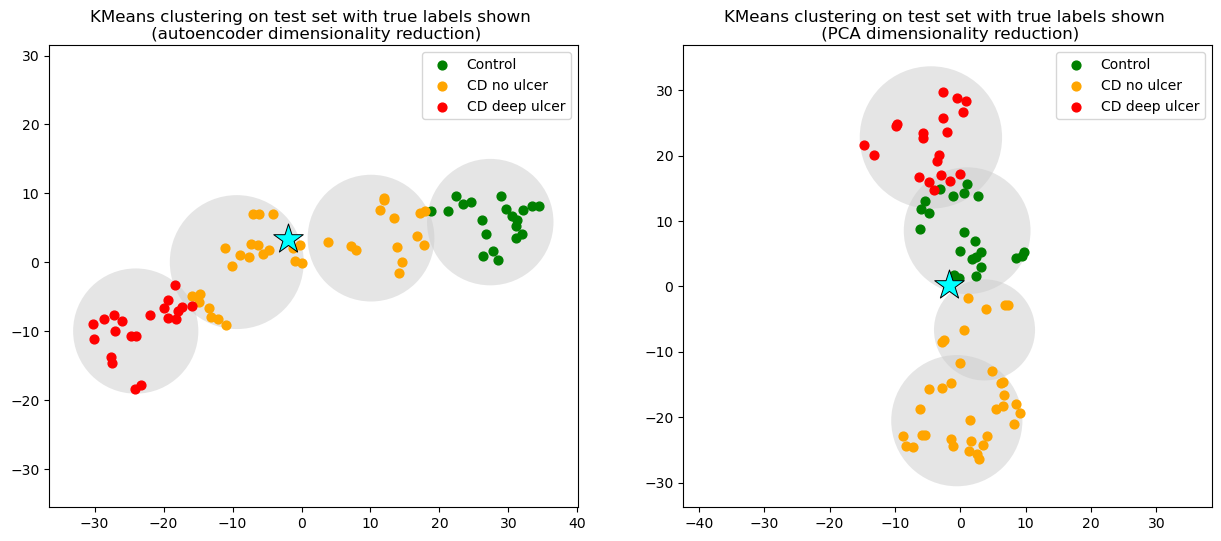

In [124]:
_, _ = plot_final_km_models(km_labels_list, km_models_list, train_set_list, test_set_list, centers_list, radii_list, num_c, selected_patient_idx=selected_patient_idx)

### Modify gene expressions for the selected patient - 120 genes

In [125]:
test_set = x_test_scaled.copy()
full_ds = full_ds.copy()

In [126]:
with open("most_diff_genes_115", "rb") as fp:   # Unpickling
    most_diff_genes = pickle.load(fp)

most_diff_genes

['FDCSP', 'FNDC4', 'JKAMP', 'RUFY4']

In [127]:
test_set = modify_expression(pid, most_diff_genes, test_set)
test_set.loc[test_set.index.str.startswith(pid)]

,AADAC,APOA1,APOA4,APOB,APOC3,AQP9,C6,CEACAM7,CHI3L1,ABCC2,...,TAF15,ZFYVE20,LOC100420253,LY6G5B,C5orf58,RSL24D1P1,MIEN1,PCBP1_AS1,LOC100133165,DNAJB8
Patient_ID,,,,,,,,,,,,,,,,,,,,,
46_CD_deep_ulcer,0.438089,0.482152,0.410237,0.378247,0.438691,0.705762,0.339106,0.559666,0.878088,0.228893,...,0.403676,0.276644,0.0,0.548505,0.391732,0.0,0.243567,0.144529,0.0,0.0


In [128]:
full_ds[-len(test_set):] = test_set

### Re-encode and refit models

In [129]:
# gmm_pca, X_train_pca, X_test_pca = re_encode(full_ds, perplexity, num_c, "PCA")
# gmm_ae, X_train_ae, X_test_ae = re_encode(full_ds, perplexity, num_c, "AE")

# gmm_models_list = [gmm_ae, gmm_pca]
# train_set_list = [X_train_ae, X_train_pca]
# test_set_list = [X_test_ae, X_test_pca]

kmeans_pca, X_train_pca, X_test_pca, _, k_labels_test_pca, centers_pca, radii_pca = re_encode_km(full_ds, perplexity, num_c, "PCA")
kmeans_ae, X_train_ae, X_test_ae, _, k_labels_test_ae, centers_ae, radii_ae = re_encode_km(full_ds, perplexity, num_c, "AE")

km_labels_list = [k_labels_test_ae, k_labels_test_pca]
km_models_list = [kmeans_ae, kmeans_pca]
train_set_list = [X_train_ae, X_train_pca]
test_set_list = [X_test_ae, X_test_pca]
centers_list = [centers_ae, centers_pca]
radii_list = [radii_ae, radii_pca]

C:\Users\shard\anaconda3\envs\mvp4\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\shard\anaconda3\envs\mvp4\lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\Users\shard\anaconda3\envs\mvp4\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\shard\anaconda3\envs\mvp4\lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. Y

C:\Users\shard\AppData\Local\Temp\ipykernel_13280\161184728.py:33: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  ax.scatter(X_test[test_set_clusters==i, 0], X_test[test_set_clusters==i, 1], c=colours[i], label=cluster_names[i], s=40, cmap='viridis', zorder=2)


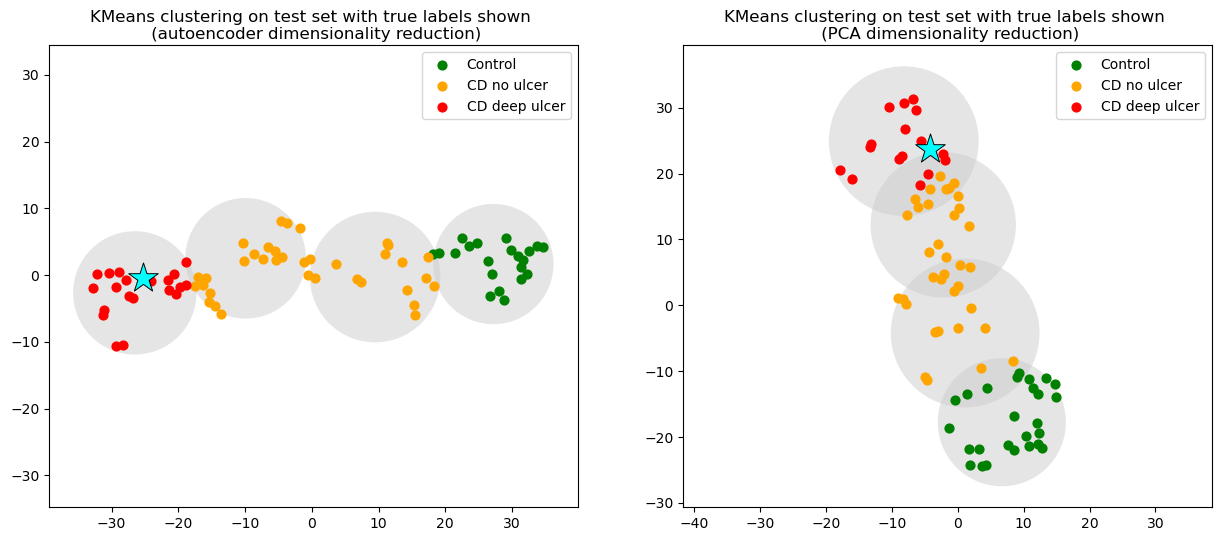

In [130]:
_, _ = plot_final_km_models(km_labels_list, km_models_list, train_set_list, test_set_list, centers_list, radii_list, num_c, selected_patient_idx=selected_patient_idx)

## KMeans Explainability - CD No Ulcer patient

In [131]:
test_set = x_test_scaled.copy()
full_ds = full_ds.copy()

### Encode and fit models

In [132]:
# gmm_pca, X_train_pca, X_test_pca = re_encode(full_ds, perplexity, num_c, "PCA")
# gmm_ae, X_train_ae, X_test_ae = re_encode(full_ds, perplexity, num_c, "AE")

# gmm_models_list = [gmm_ae, gmm_pca]
# train_set_list = [X_train_ae, X_train_pca]
# test_set_list = [X_test_ae, X_test_pca]

kmeans_pca, X_train_pca, X_test_pca, _, k_labels_test_pca, centers_pca, radii_pca = re_encode_km(full_ds, perplexity, num_c, "PCA")
kmeans_ae, X_train_ae, X_test_ae, _, k_labels_test_ae, centers_ae, radii_ae = re_encode_km(full_ds, perplexity, num_c, "AE")

km_labels_list = [k_labels_test_ae, k_labels_test_pca]
km_models_list = [kmeans_ae, kmeans_pca]
train_set_list = [X_train_ae, X_train_pca]
test_set_list = [X_test_ae, X_test_pca]
centers_list = [centers_ae, centers_pca]
radii_list = [radii_ae, radii_pca]

C:\Users\shard\anaconda3\envs\mvp4\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\shard\anaconda3\envs\mvp4\lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\Users\shard\anaconda3\envs\mvp4\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\shard\anaconda3\envs\mvp4\lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. Y

### Select patient

In [133]:


selected_patient, pid = get_patient(test_set, 'CD_plain', frac=4)
selected_patient

,AADAC,APOA1,APOA4,APOB,APOC3,AQP9,C6,CEACAM7,CHI3L1,ABCC2,...,TAF15,ZFYVE20,LOC100420253,LY6G5B,C5orf58,RSL24D1P1,MIEN1,PCBP1_AS1,LOC100133165,DNAJB8
Patient_ID,,,,,,,,,,,,,,,,,,,,,
52_CD_plain,0.616594,0.67436,0.771113,0.719969,0.736123,0.652282,0.026984,0.597116,0.521966,0.446241,...,0.415668,0.189575,0.0,0.476761,0.50392,0.0,0.399539,0.102,0.0,0.0


In [134]:
ind = test_set.index
selected_patient_idx = ind.get_loc(pid)
selected_patient_idx

17

C:\Users\shard\AppData\Local\Temp\ipykernel_13280\161184728.py:33: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  ax.scatter(X_test[test_set_clusters==i, 0], X_test[test_set_clusters==i, 1], c=colours[i], label=cluster_names[i], s=40, cmap='viridis', zorder=2)


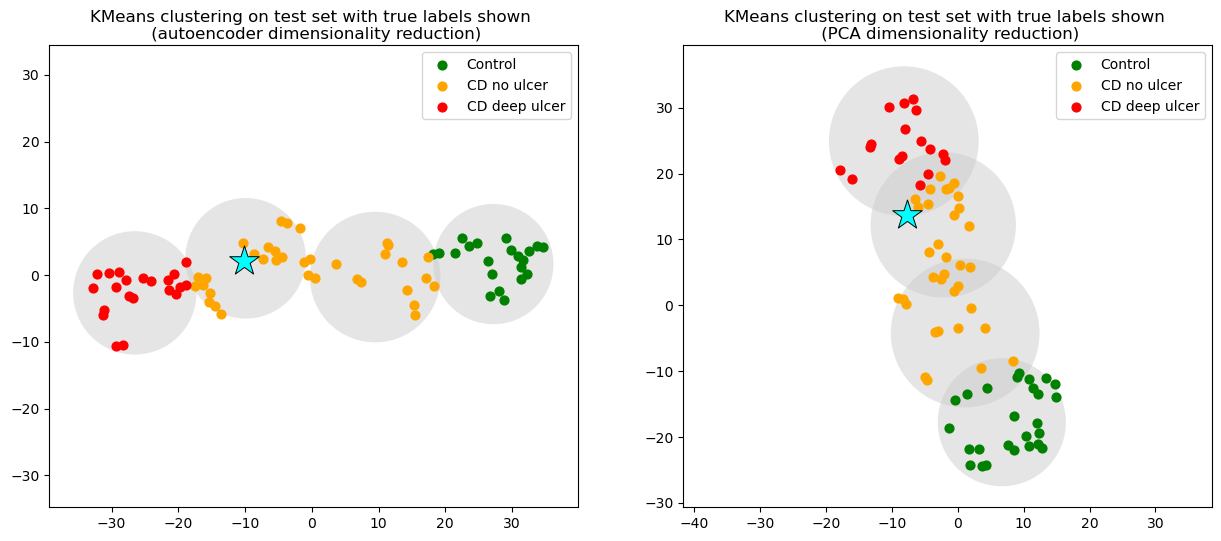

In [135]:
_, _ = plot_final_km_models(km_labels_list, km_models_list, train_set_list, test_set_list, centers_list, radii_list, num_c, selected_patient_idx=selected_patient_idx)

### Modify gene expressions for the selected patient - 60 genes

In [136]:
test_set = x_test_scaled.copy()
full_ds = full_ds.copy()

In [137]:
with open("most_diff_genes_60", "rb") as fp:   # Unpickling
    most_diff_genes_60 = pickle.load(fp)

most_diff_genes

['FDCSP', 'FNDC4', 'JKAMP', 'RUFY4']

In [138]:
test_set = modify_expression(pid, most_diff_genes_60, test_set)
test_set.loc[test_set.index.str.startswith(pid)]

,AADAC,APOA1,APOA4,APOB,APOC3,AQP9,C6,CEACAM7,CHI3L1,ABCC2,...,TAF15,ZFYVE20,LOC100420253,LY6G5B,C5orf58,RSL24D1P1,MIEN1,PCBP1_AS1,LOC100133165,DNAJB8
Patient_ID,,,,,,,,,,,,,,,,,,,,,
52_CD_plain,0.837271,0.67436,0.800854,0.834515,0.740914,0.652282,0.638968,0.173455,0.313654,0.836045,...,0.415668,0.189575,0.0,0.476761,0.50392,0.0,0.399539,0.102,0.0,0.0


In [139]:
full_ds[-len(test_set):] = test_set

### Re-encode and refit models

In [140]:
# gmm_pca, X_train_pca, X_test_pca = re_encode(full_ds, perplexity, num_c, "PCA")
# gmm_ae, X_train_ae, X_test_ae = re_encode(full_ds, perplexity, num_c, "AE")

# gmm_models_list = [gmm_ae, gmm_pca]
# train_set_list = [X_train_ae, X_train_pca]
# test_set_list = [X_test_ae, X_test_pca]

kmeans_pca, X_train_pca, X_test_pca, _, k_labels_test_pca, centers_pca, radii_pca = re_encode_km(full_ds, perplexity, num_c, "PCA")
kmeans_ae, X_train_ae, X_test_ae, _, k_labels_test_ae, centers_ae, radii_ae = re_encode_km(full_ds, perplexity, num_c, "AE")

km_labels_list = [k_labels_test_ae, k_labels_test_pca]
km_models_list = [kmeans_ae, kmeans_pca]
train_set_list = [X_train_ae, X_train_pca]
test_set_list = [X_test_ae, X_test_pca]
centers_list = [centers_ae, centers_pca]
radii_list = [radii_ae, radii_pca]

C:\Users\shard\anaconda3\envs\mvp4\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\shard\anaconda3\envs\mvp4\lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\Users\shard\anaconda3\envs\mvp4\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\shard\anaconda3\envs\mvp4\lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. Y

C:\Users\shard\AppData\Local\Temp\ipykernel_13280\161184728.py:33: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  ax.scatter(X_test[test_set_clusters==i, 0], X_test[test_set_clusters==i, 1], c=colours[i], label=cluster_names[i], s=40, cmap='viridis', zorder=2)


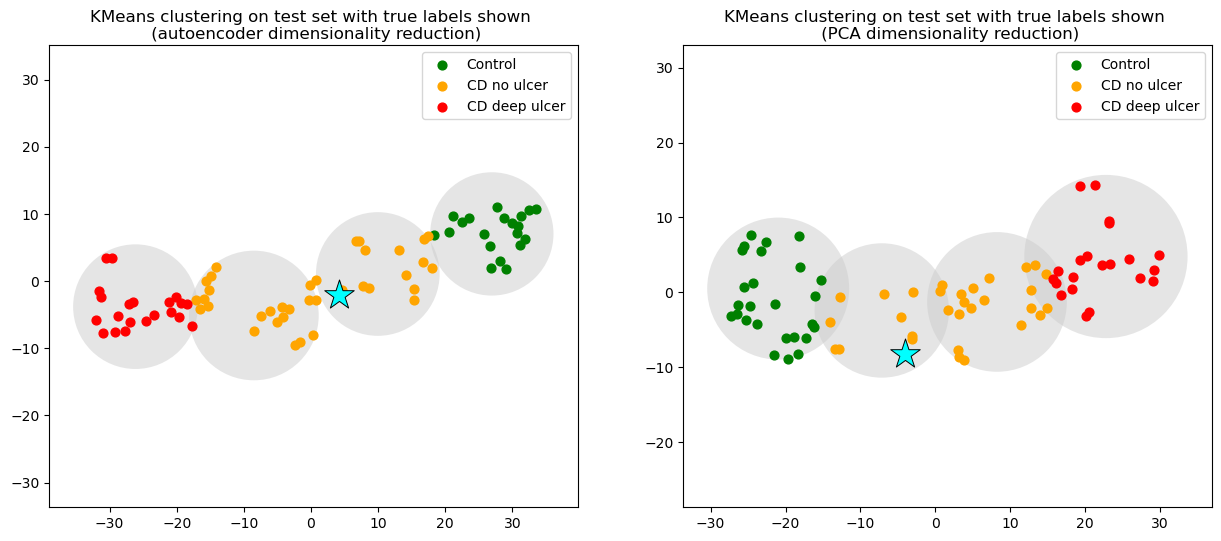

In [141]:
_, _ = plot_final_km_models(km_labels_list, km_models_list, train_set_list, test_set_list, centers_list, radii_list, num_c, selected_patient_idx=selected_patient_idx)

### Modify gene expressions for the selected patient - 120 genes

In [142]:
test_set = x_test_scaled.copy()
full_ds = full_ds.copy()

In [143]:
with open("most_diff_genes_115", "rb") as fp:   # Unpickling
    most_diff_genes = pickle.load(fp)

most_diff_genes

['FDCSP', 'FNDC4', 'JKAMP', 'RUFY4']

In [144]:
test_set = modify_expression(pid, most_diff_genes, test_set)
test_set.loc[test_set.index.str.startswith(pid)]

,AADAC,APOA1,APOA4,APOB,APOC3,AQP9,C6,CEACAM7,CHI3L1,ABCC2,...,TAF15,ZFYVE20,LOC100420253,LY6G5B,C5orf58,RSL24D1P1,MIEN1,PCBP1_AS1,LOC100133165,DNAJB8
Patient_ID,,,,,,,,,,,,,,,,,,,,,
52_CD_plain,0.616594,0.67436,0.771113,0.719969,0.736123,0.652282,0.026984,0.597116,0.521966,0.446241,...,0.415668,0.189575,0.0,0.476761,0.50392,0.0,0.399539,0.102,0.0,0.0


In [145]:
full_ds[-len(test_set):] = test_set

### Re-encode and refit models

In [146]:
# gmm_pca, X_train_pca, X_test_pca = re_encode(full_ds, perplexity, num_c, "PCA")
# gmm_ae, X_train_ae, X_test_ae = re_encode(full_ds, perplexity, num_c, "AE")

# gmm_models_list = [gmm_ae, gmm_pca]
# train_set_list = [X_train_ae, X_train_pca]
# test_set_list = [X_test_ae, X_test_pca]

kmeans_pca, X_train_pca, X_test_pca, _, k_labels_test_pca, centers_pca, radii_pca = re_encode_km(full_ds, perplexity, num_c, "PCA")
kmeans_ae, X_train_ae, X_test_ae, _, k_labels_test_ae, centers_ae, radii_ae = re_encode_km(full_ds, perplexity, num_c, "AE")

km_labels_list = [k_labels_test_ae, k_labels_test_pca]
km_models_list = [kmeans_ae, kmeans_pca]
train_set_list = [X_train_ae, X_train_pca]
test_set_list = [X_test_ae, X_test_pca]
centers_list = [centers_ae, centers_pca]
radii_list = [radii_ae, radii_pca]

C:\Users\shard\anaconda3\envs\mvp4\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\shard\anaconda3\envs\mvp4\lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\Users\shard\anaconda3\envs\mvp4\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\shard\anaconda3\envs\mvp4\lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. Y

C:\Users\shard\AppData\Local\Temp\ipykernel_13280\161184728.py:33: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  ax.scatter(X_test[test_set_clusters==i, 0], X_test[test_set_clusters==i, 1], c=colours[i], label=cluster_names[i], s=40, cmap='viridis', zorder=2)


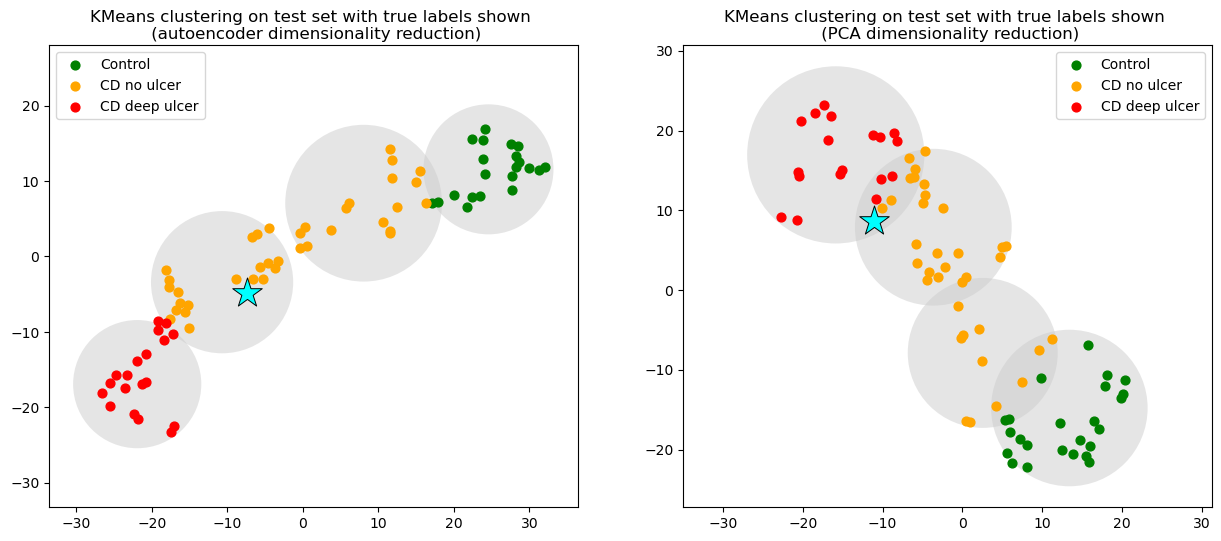

In [147]:
_, _ = plot_final_km_models(km_labels_list, km_models_list, train_set_list, test_set_list, centers_list, radii_list, num_c, selected_patient_idx=selected_patient_idx)